# __HUMAN ACTIVITY RECOGNITION__
🚶,🏃,👨‍🦼,🧍...

_UChicago | MSCA 37011: Deep Learning and Image Recognition_

- Data source: 
http://www.cis.fordham.edu/wisdm/dataset.php

- Cited Paper: 
  - Jennifer R. Kwapisz, Gary M. Weiss and Samuel A. Moore (2010). Activity Recognition using Cell Phone Accelerometers, Proceedings of the Fourth International Workshop on Knowledge Discovery from Sensor Data (at KDD-10), Washington DC.
    http://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf

- Reference:
  
    https://ieeexplore.ieee.org/document/7178838

    https://arxiv.org/pdf/1905.00599.pdf
  
    https://www.kaggle.com/morrisb/what-does-your-smartphone-know-about-you 
    
    https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0
    
    https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/


## Import Libraries

In [0]:
# Downgrade matplotlib to plot the heatmap for confusion matrix
# Run this code and restart runtime
pip install matplotlib==3.1.0

In [0]:
from __future__ import print_function
from matplotlib import pyplot as plt
#%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
# Default seaborn look and feel
sns.set() 
plt.style.use('ggplot')
import missingno as msno

# import coremltools
from scipy import stats
from IPython.display import display, HTML

# sklearn packages
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model, datasets,metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# pickle
import pickle

# keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.layers.embeddings import Embedding
from keras.layers import BatchNormalization

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set standard parameters
pd.options.display.float_format = '{:.1f}'.format

print('keras version ', keras.__version__)

Using TensorFlow backend.


keras version  2.2.5


## Import Drive


In [0]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
!ls "/content/drive/My Drive"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
'Colab Notebooks'   Deep_Learning_Project  'Getting started.pdf'   ML_Project


## Setting Labels

In [0]:
# Labels using throughout the dataset and modeling
labels = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']

## Import Dataset

Missing values:
            0
user-id    0
activity   0
timestamp  0
x-axis     0
y-axis     0
z-axis     1


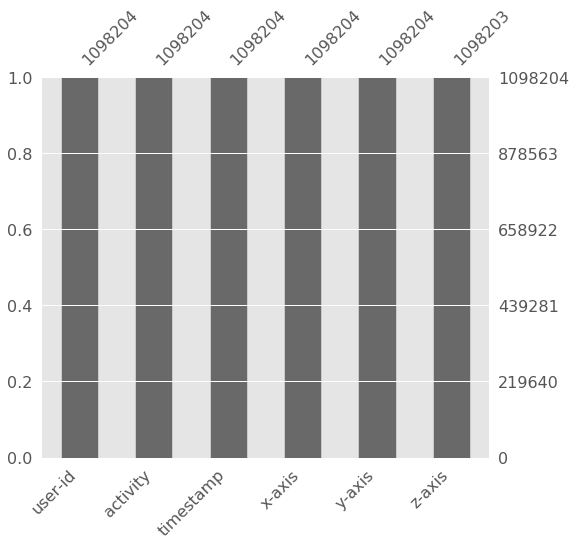

In [0]:
def read_data(file_path):

    col_names = ['user-id', 'activity', 'timestamp','x-axis','y-axis','z-axis']
    df = pd.read_csv('/content/drive/My Drive/Deep_Learning_Project/WISDM_ar_v1.1_raw.txt', header=None, names=col_names)
    
    ''' Remove ";" in the last column and transform such column to float explicitly'''
    df['z-axis'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    
    '''Check missing value'''
    print('Missing values:\n', pd.DataFrame(df.isnull().sum()))
    msno.bar(df, figsize=(8,7))

    '''Drop NaN'''
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
        
# Load data set containing all the data from csv
df = read_data('WISDM_ar_v1.1_raw.txt')

__Remove 1 missing value__

## __II. EDA__

____
Accelerometer data was collected every 50ms, so we have 20 samples per second.
(1s = 1000ms)


- x-axis captures horizontal movement of the user’s leg
- y- axis captures the upward and downward motion
- z-axis captures the forward movement of the leg

<div>
<img src="https://www.sciencebuddies.org/Files/12273/8/gsj-phone-axes-rotate.png" width="250"/>
</div>

Six different activities across 36 users:  Walking, Jogging, Standing, Sitting, Upstairs, and Downstairs.

Total: 1,098,203 records

____

In [0]:
# Describe the data
print('Data Shape:', df.shape)
df.head(10)

Data Shape: (1098203, 6)


user-id activity       timestamp  x-axis  y-axis  z-axis
0       33  Jogging  49105962326000    -0.7    12.7     0.5
1       33  Jogging  49106062271000     5.0    11.3     1.0
2       33  Jogging  49106112167000     4.9    10.9    -0.1
3       33  Jogging  49106222305000    -0.6    18.5     3.0
4       33  Jogging  49106332290000    -1.2    12.1     7.2
5       33  Jogging  49106442306000     1.4    -2.5    -6.5
6       33  Jogging  49106542312000    -0.6    10.6     5.7
7       33  Jogging  49106652389000    -0.5    13.9     7.1
8       33  Jogging  49106762313000    -8.4    11.4     5.1
9       33  Jogging  49106872299000     1.0     1.4     1.6

In [0]:
# Number of users and unique id:
print('Total_id:', len(df['user-id'].unique()))
df['user-id'].unique()

Total_id: 36


array([33, 17, 20, 29, 13, 15,  6, 27, 36, 18, 32, 35, 11, 16,  5, 10, 28,
       26, 14, 24, 12, 23,  4, 30, 34,  8, 31, 21,  3, 22,  1,  9, 25,  2,
        7, 19])

___
#### __2.1 Plot total numbers by activity and number of activity by users__

*   Imbalance dataset: 70% of activities: Walking and Jogging 🚶 🏃
*   Number of activities varies by users
___

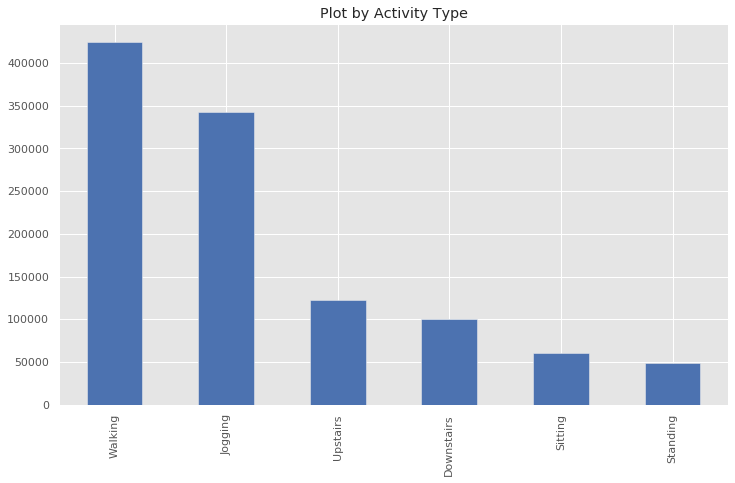

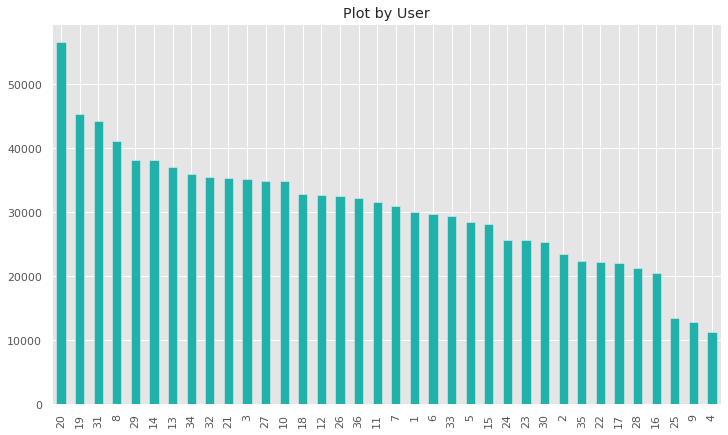

In [0]:
# Show how many training examples exist for each of the six activities
fig= plt.figure(figsize=(12,7))
df['activity'].value_counts().plot(kind='bar', title='Plot by Activity Type', color ='b')
plt.show()

# Training by records (users)
fig= plt.figure(figsize=(12,7))
df['user-id'].value_counts().plot(kind='bar',title='Plot by User', color ='lightseagreen')
plt.show()

___
### 2.2 Crosstab activity by user

Number of records and actitives vary by users
___





In [0]:
# Acivity by users
pd.crosstab(df['user-id'], df['activity'], margins = True, margins_name = 'Total').sort_values(by = 'Total', ascending = False)

activity  Downstairs  Jogging  Sitting  Standing  Upstairs  Walking    Total
user-id                                                                     
Total         100427   342176    59939     48395    122869   424397  1098203
20              4673    12948    15644      5389      4844    13134    56632
19              2614    16201     2534      2132      4280    17622    45383
31              3892    14075     2148      2612      4679    16876    44282
8               3346    10313     2699      3269      4453    17108    41188
29              4329    12788     2319      1603      4786    12420    38245
14              2875    13279        0         0      8179    13859    38192
13              4241    12329     1179      1659      4638    13047    37093
34              2856    12869     1575      1349      3921    13377    35947
32              2343    12245     3059      1669      3814    12376    35506
21              4036     9593     1609      2859      4841    12498    35436
3               3326    11018     1609      2824      3411    12973    35161
27              3460    12038     2099      1630      3255    12476    34958
10              3795    12084        0      1660      4296    13048    34883
18              2415    11992     1467      1954      2425    12558    32811
12              2870    12360     2289      1670      2654    10798    32641
26              3837    11913        0         0      3618    13210    32578
36              4167    12038     2500      1925      5431     6200    32261
11              2674    12454        0         0      4392    12138    31658
7               2257     9183     2529      2364      3601    11033    30967
1               2941    11056        0         0      3120    12861    29978
6               1433    11818     1679       709      1666    12399    29704
33              4535     2946     3248      1612      2214    14898    29453
5               3281     6405     1664      1515      3387    12257    28509
15              1762    12799        0         0      2064    11529    28154
24              2929    12278      690       544      3039     6256    25736
23              1939    12309        0         0      4836     6589    25673
30              3872        0     1559      3099      4226    12579    25335
2                  0    11786        0         0         0    11739    23525
35                 0    12564     1599      1069         0     7162    22394
22              3627     6224        0         0      5430     7029    22310
17              3767     2887        0         0      5689     9677    22020
28              2997        0        0      1300      2892    14169    21358
16              1575        0     2984      1979      1411    12521    20470
25                 0     6489        0         0         0     6979    13468
9                  0        0        0         0         0    12923    12923
4               1763      895     1257         0      1377     6079    11371

___
### 2.3 tSNE - Activities Separable?
- The idea of using tSNE is to visualize the pattern of different of acitivities by 2D plot.
- It is computation expensive to run tSNE for the whole dataset (1 million instances). Therefore, I pick 100,000 records, including 6 different activities to apply tSNE and visualize such activites.
- Standing and sitting are easy to recognize ( locate in separate regions) while Upstairs and Downstairs are overlap, on top of each other as well as Walking and Jogging. This suggests that classifying the Upstairs and Downstairs activity would be challenging!
___

In [0]:
df[170000:270000].groupby(by = 'activity').count()

user-id  timestamp  x-axis  y-axis  z-axis  ActivityEncoded
activity                                                               
Downstairs     9060       9060    9060    9060    9060             9060
Jogging       35100      35100   35100   35100   35100            35100
Sitting        4599       4599    4599    4599    4599             4599
Standing       3555       3555    3555    3555    3555             3555
Upstairs      10352      10352   10352   10352   10352            10352
Walking       37334      37334   37334   37334   37334            37334

#### Standardize - tSNE

Text(0.5, 1.0, 'TSNE Reduction Colored by Activity')

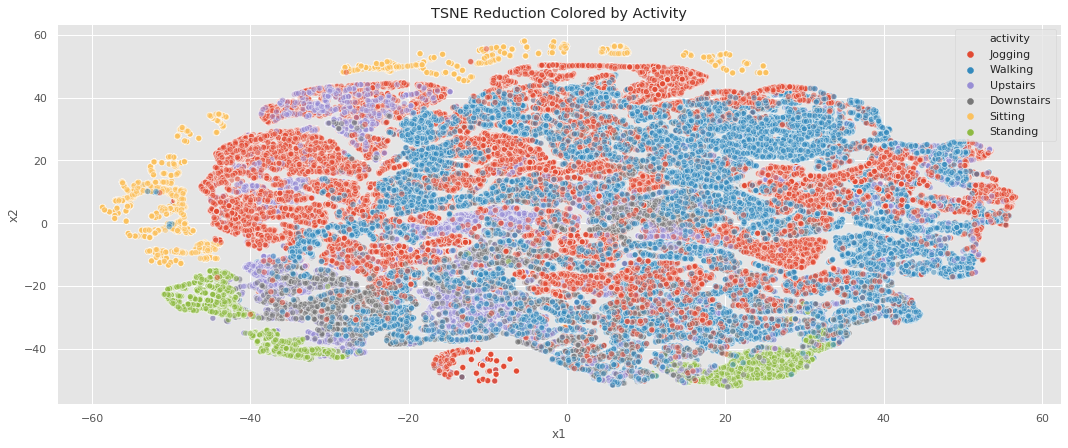

In [0]:
# Create datasets
tsne_data = df[['x-axis','y-axis','z-axis']][170000:270000].copy()

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=911, n_components=2)
tsne_transformed = tsne.fit_transform(tsne_data)

# Plot data
dftsne = pd.DataFrame(tsne_transformed)
dftsne['activity'] = df['activity'][170000:270000].reset_index(drop=True)
dftsne.columns = ['x1','x2','activity']

fig, ax = plt.subplots(figsize=(18, 7))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='activity',legend="full",alpha=0.5,ax=ax)
ax.set_title('TSNE Reduction Colored by Activity')

#### Normalize - tSNE

Text(0.5, 1.0, 'TSNE Reduction Colored by Activity_Normalized')

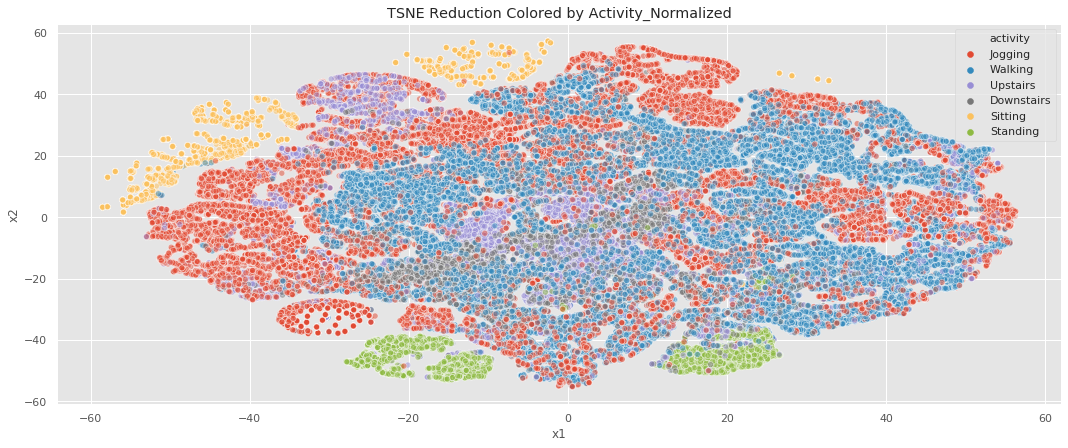

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Create datasets
tsne_normalize = df[['x-axis','y-axis','z-axis']][170000:270000].copy()

# Scale data
scaler = MinMaxScaler()
tsne_normalize = scaler.fit_transform(tsne_normalize)

# Transform data
tsne_norm = TSNE(random_state=911, n_components=2)
tsne_norm_transformed = tsne_norm.fit_transform(tsne_normalize)

# Plot data
dftsne_norm = pd.DataFrame(tsne_norm_transformed)
dftsne_norm['activity'] = df['activity'][170000:270000].reset_index(drop=True)
dftsne_norm.columns = ['x1','x2','activity']

fig, ax = plt.subplots(figsize=(18, 7))
sns.scatterplot(data=dftsne_norm,x='x1',y='x2',hue='activity',legend="full",alpha=0.5,ax=ax)
ax.set_title('TSNE Reduction Colored by Activity_Normalized')

#### Without Scaling - tSNE

Text(0.5, 1.0, 'TSNE Reduction Colored by Activity')

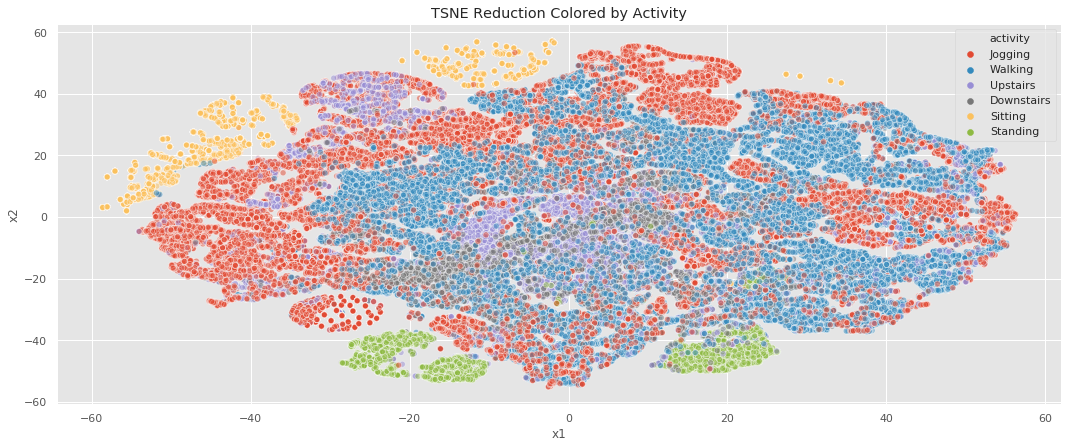

In [0]:
# Create datasets
tsne_raw = df[['x-axis','y-axis','z-axis']][170000:270000].copy()

# Transform data
tsne_orig = TSNE(random_state=911, n_components=2)
tsne_orig_transformed = tsne_orig.fit_transform(tsne_raw)

# Plot data
dftsne_orig = pd.DataFrame(tsne_orig_transformed)
dftsne_orig['activity'] = df['activity'][170000:270000].reset_index(drop=True)
dftsne_orig.columns = ['x1','x2','activity']

fig, ax = plt.subplots(figsize=(18, 7))
sns.scatterplot(data=dftsne_orig,x='x1',y='x2',hue='activity',legend="full",alpha=0.5,ax=ax)
ax.set_title('TSNE Reduction Colored by Activity')

In [0]:
# Pickle tnse file cause it takes long time to process.
import pickle
pickle.dump(tsne_transformed, open("tsne_transformed.p", "wb"))
pickle.dump(tsne_norm_transformed, open("tsne_norm_transformed.p", "wb"))
pickle.dump(tsne_orig_transformed, open("tsne_orig_transformed.p", "wb"))

___
### 2.4 Staircase Walking Style Different By User?
- Walking pattern varies by users
- Some people have very similar path in terms of walking Upstairs and Downstairs. This finding, once again, confirms the challenge in classifying such two activities
___

#### Walking pattern by user

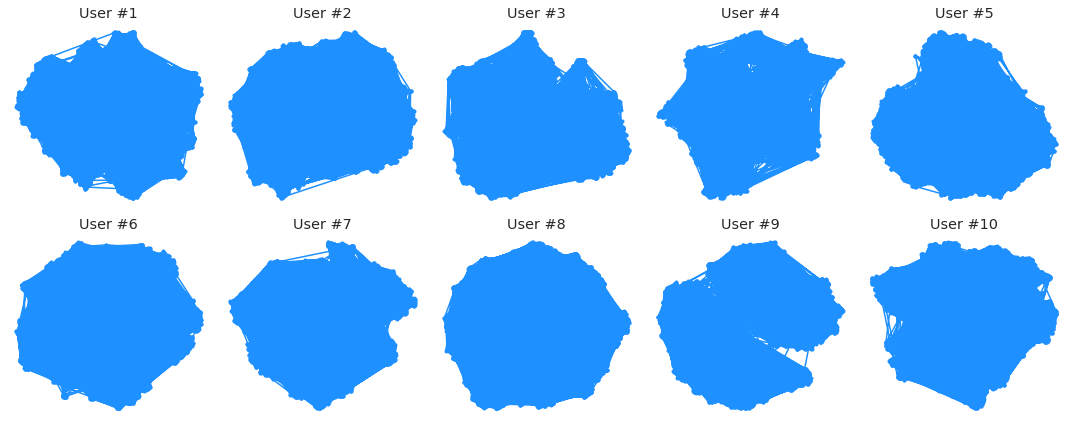

In [0]:
fig, ax = plt.subplots(2, 5, figsize=(15,6))

for person in range(0, 10):
    # Get data
    single_person = df[(df['activity']=='Walking') & (df['user-id']==(person+1))].drop(['user-id', 'activity','timestamp'], axis=1)

    # Transform data
    tsne = TSNE(random_state=911)
    tsne_transformed_person = tsne.fit_transform(single_person)
    
    # Create plot
    ax[person//5][person%5].plot(tsne_transformed_person[:,0], tsne_transformed_person[:,1], '.-', color='dodgerblue')
    ax[person//5][person%5].set_title('User #{}'.format(person+1))
    ax[person//5][person%5].axis('off')
    
plt.tight_layout()
plt.show()

____
#### Upstairs and Downstairs by user

____



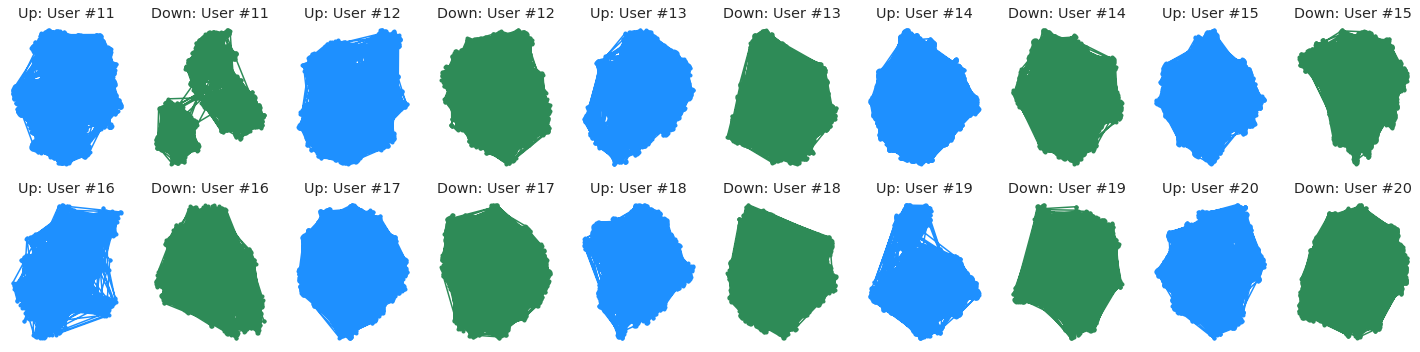

In [0]:
# Create subplots
fig, ax = plt.subplots(2, 10, figsize=(20,5))

# Iterate over each participant
for person in range(9, 20):
    # Get data
    single_person_up = df[(df['activity']=='Upstairs') & (df['user-id']==(person+1))].drop(['user-id', 'activity','timestamp'], axis=1)
    single_person_down = df[(df['activity']=='Downstairs') & (df['user-id']==(person+1))].drop(['user-id', 'activity','timestamp'], axis=1)
    # Scale data
    scl = MinMaxScaler()
    tsne_data_up = scl.fit_transform(single_person_up)
    tsne_data_down = scl.fit_transform(single_person_down)
    # Transform data
    tsne = TSNE(random_state=911, n_components=2)
    tsne_transformed_up = tsne.fit_transform(tsne_data_up)
    tsne_transformed_down = tsne.fit_transform(tsne_data_down)
    
    # Create plot
    ax[person//15][2*person%10].plot(tsne_transformed_up[:,0], tsne_transformed_up[:,1], '.-', color='dodgerblue')
    ax[person//15][2*person%10].set_title('Up: User #{}'.format(person+1))
    ax[person//15][2*person%10].axis('off')
    ax[person//15][(2*person%10)+1].plot(tsne_transformed_down[:,0], tsne_transformed_down[:,1], '.-', color='seagreen')
    ax[person//15][(2*person%10)+1].set_title('Down: User #{}'.format(person+1))
    ax[person//15][(2*person%10)+1].axis('off')
    
plt.tight_layout()
plt.show()


___
### 2.5 Plot x, y, z by activities

*   The data is recorded at a sampling rate of 20 Hz. It means 20 values per second
*   Since we show the first 200 records, each chart shows a 10 second interval for each of the six activities (0.05 * 200 = 10 seconds)
*   As we can recognize from the chart above, some users may stop or instead of moving continously, lets find out what happened inside of the data.




___

#### First 200 records

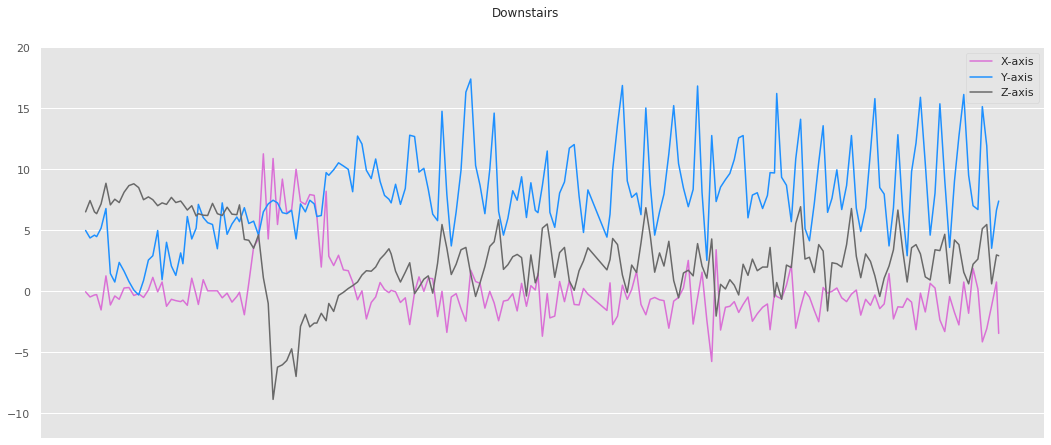

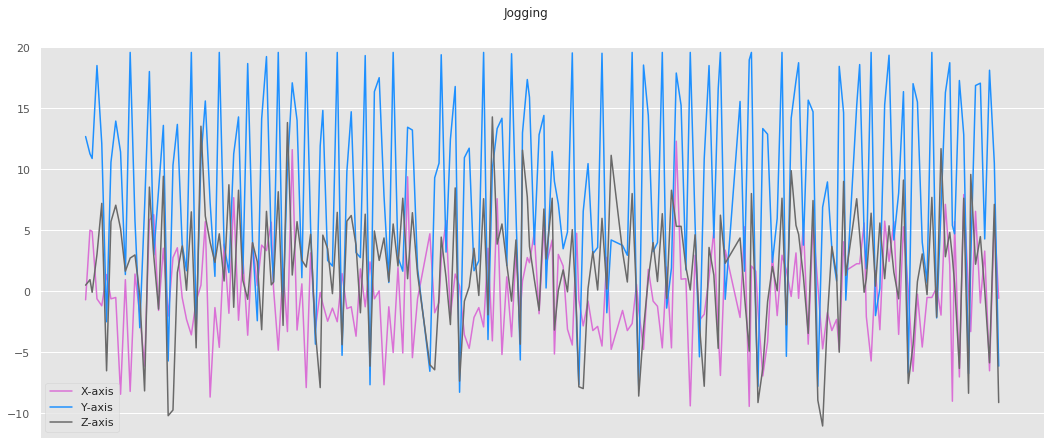

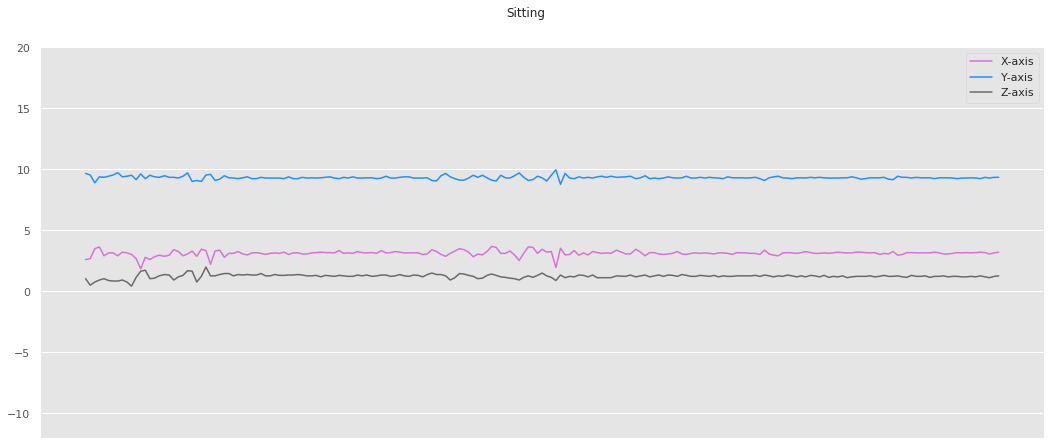

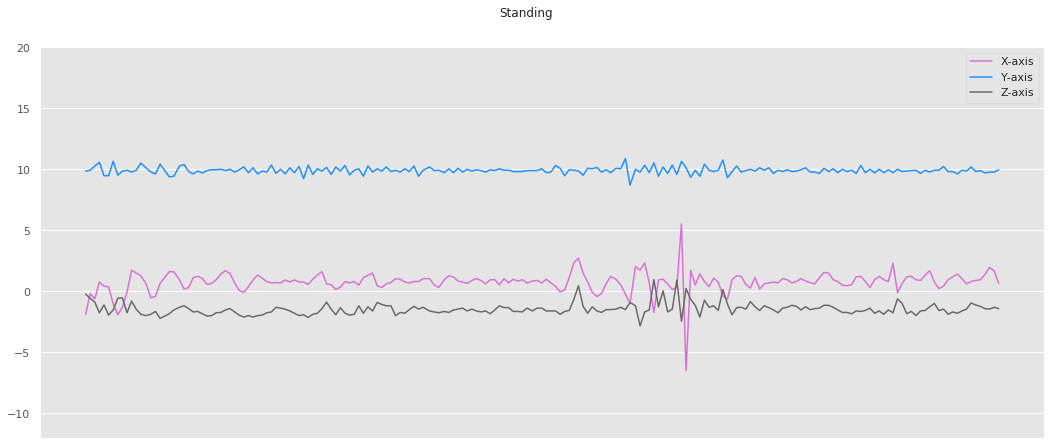

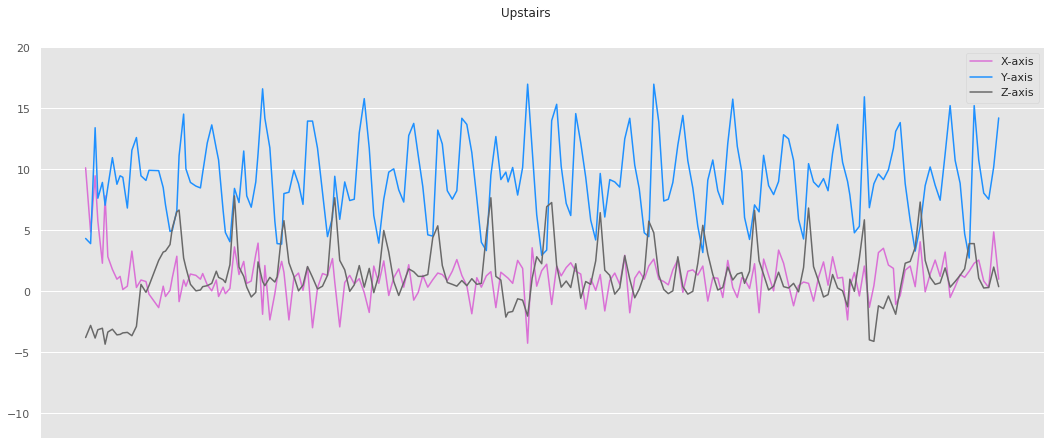

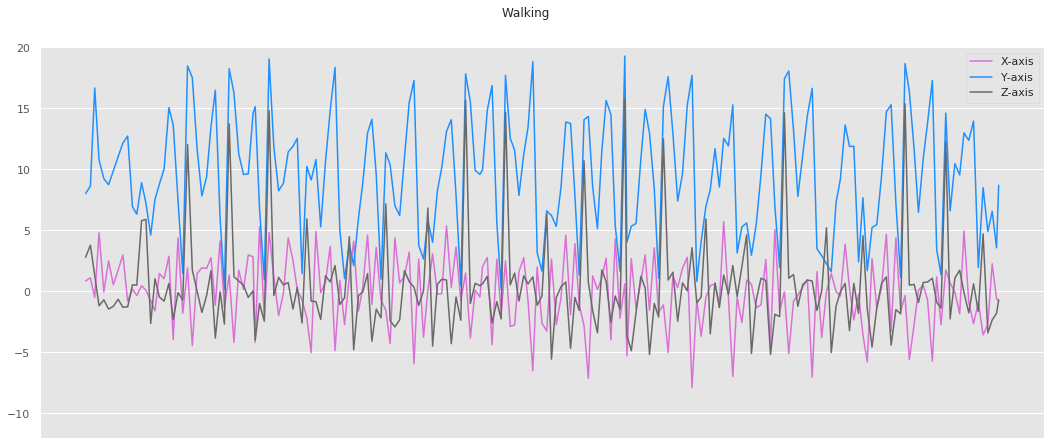

In [0]:
def plot_activity(activity, data):

    fig, ax = plt.subplots(figsize=(18, 7))
    plt.plot( data['timestamp'], data['x-axis'], color='orchid', linewidth=1.5, label="X-axis")
    plt.plot( data['timestamp'], data['y-axis'], color='dodgerblue', linewidth=1.5,  label="Y-axis")
    plt.plot( data['timestamp'], data['z-axis'], color='dimgrey', linewidth=1.5, label="Z-axis")
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(top=0.90)
    plt.suptitle(activity)
    plt.legend()
    plt.ylim(-12 , 20)
    plt.grid(True)
    plt.xticks([])
    plt.show()

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:200]
    plot_activity(activity, subset)

#### Records 200 to 400

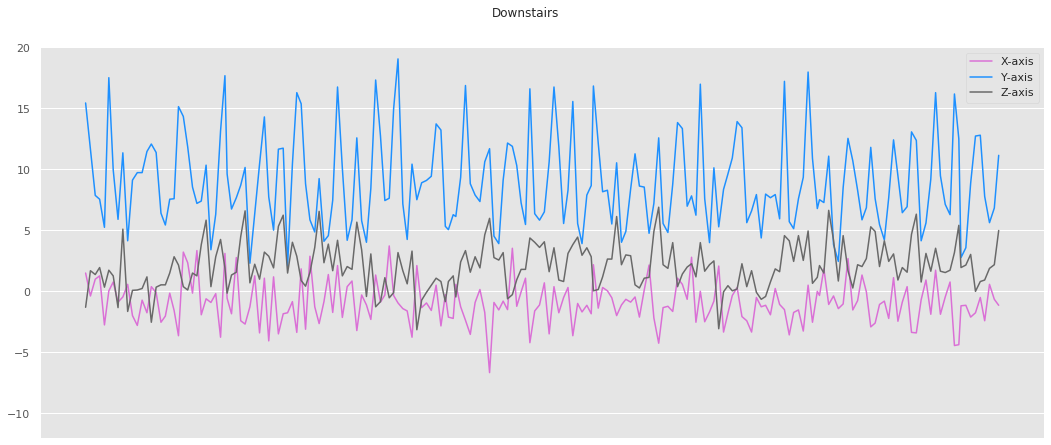

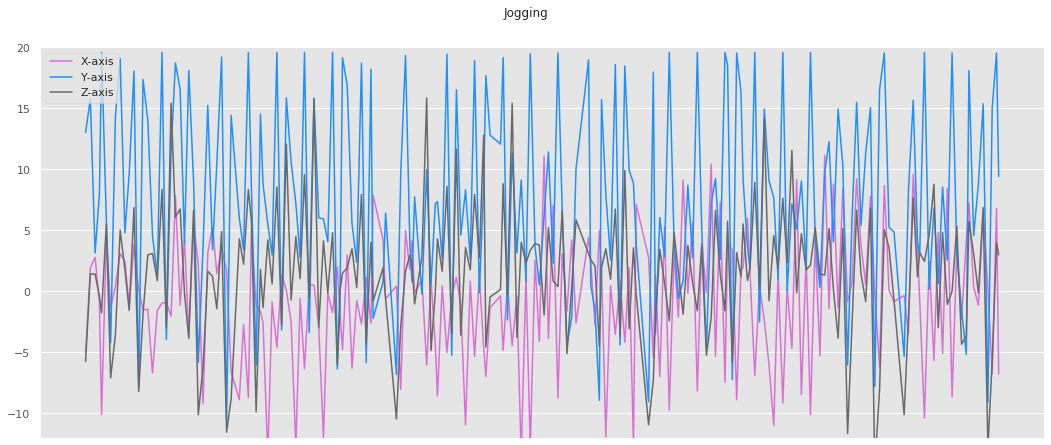

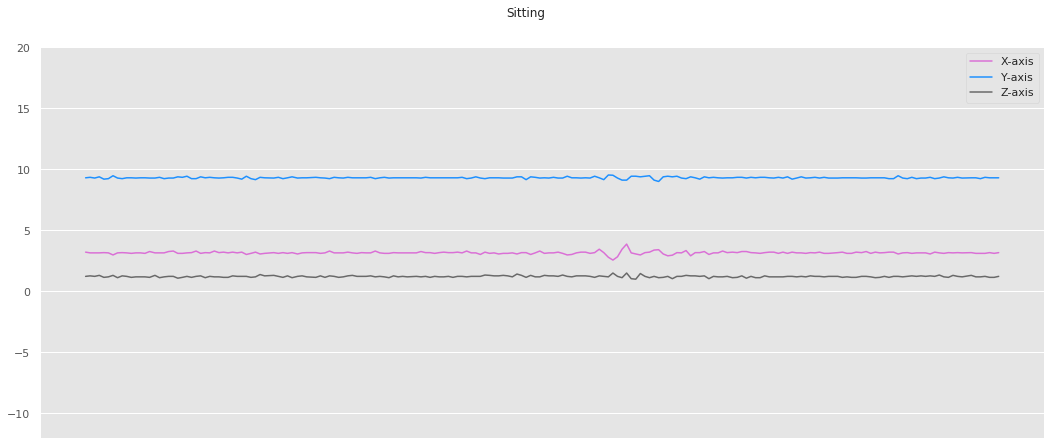

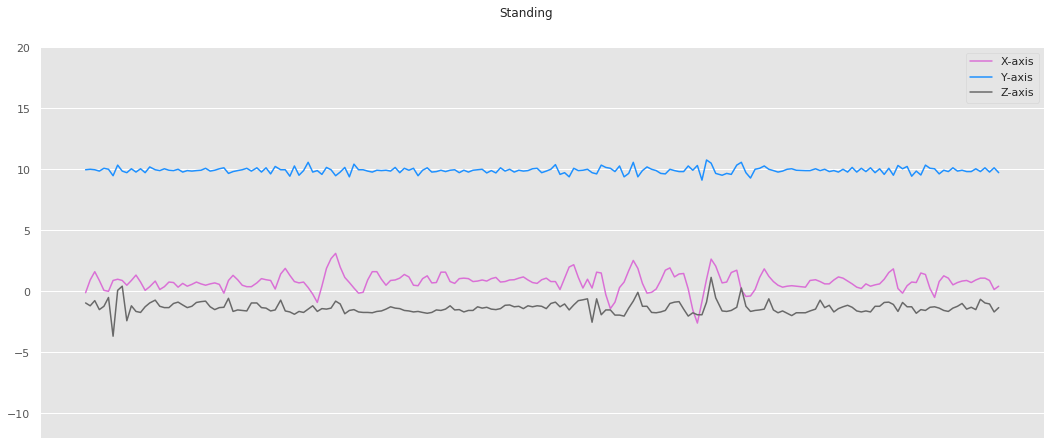

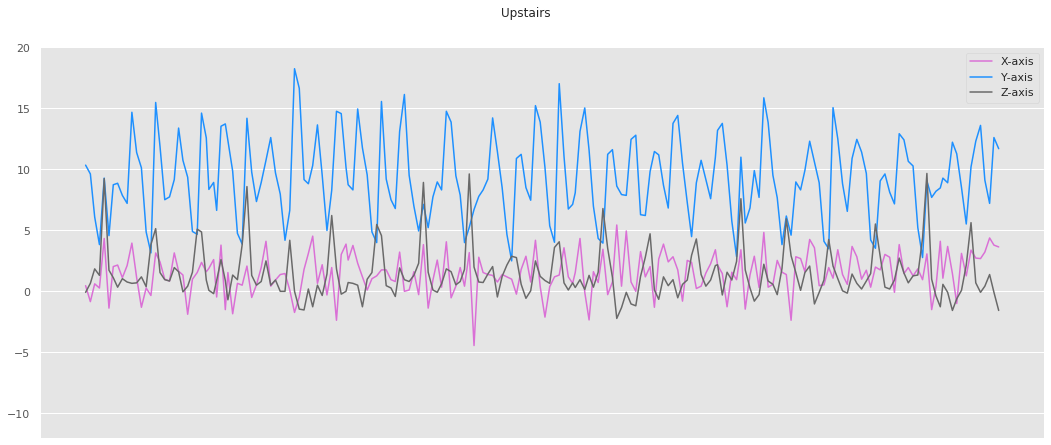

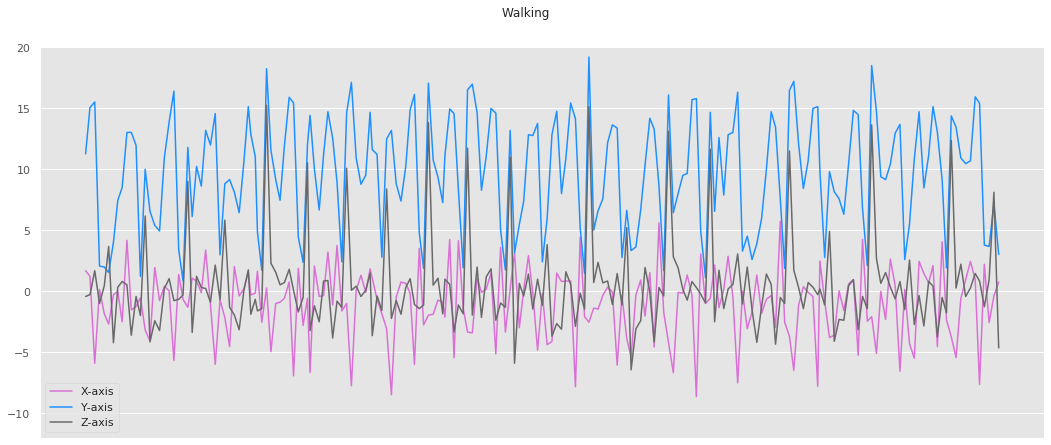

In [0]:
for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][200:400]
    plot_activity(activity, subset)

#### Records 400 to 600

Something weird here! Some activities has 0 value for both x,y and z axis.

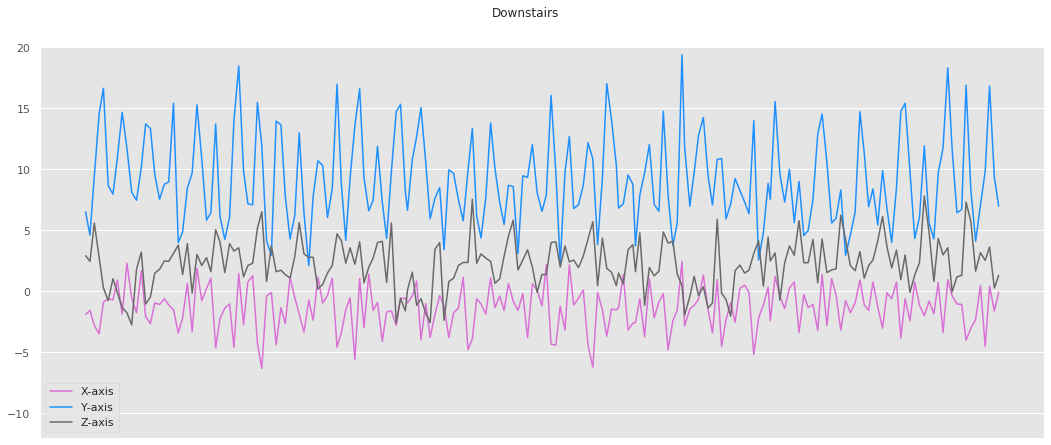

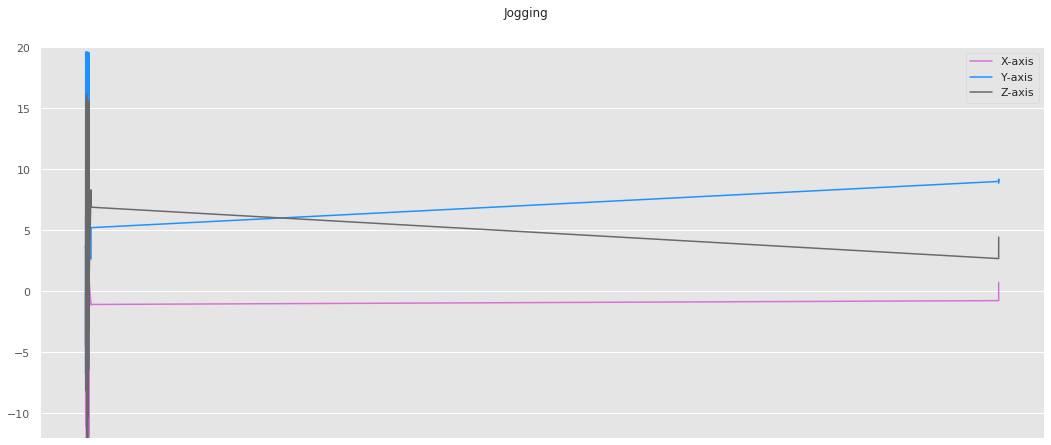

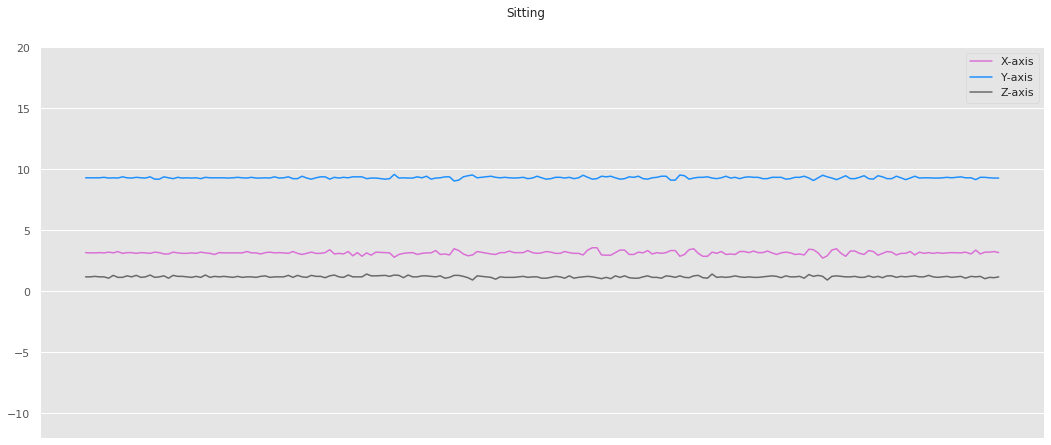

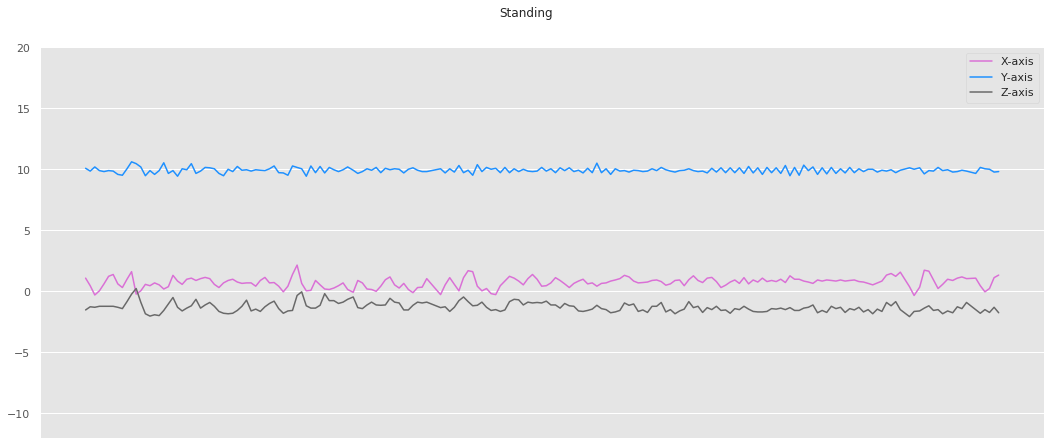

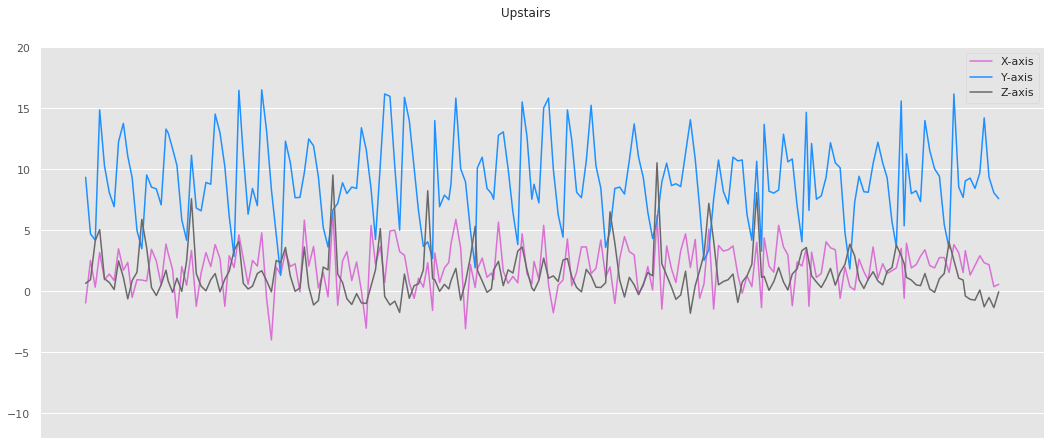

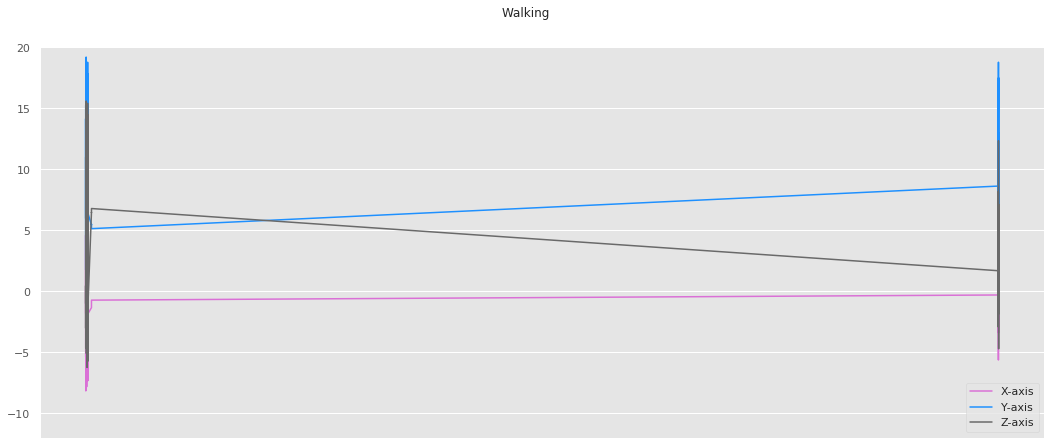

In [0]:
for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][400:600]
    plot_activity(activity, subset)

____
**CHALLENGES:** 

- Each person have a different activity pattern
- 0 timestap & 0 accelormeter data for some activities >> keep it as a noise for model or remove

The android java based accelerometer measures acceleration minus gravity, so if the device is stationary it absolutely should return 0 on every axis.

____

In [0]:
# Filter timestamp = 0
df[(df['timestamp']== 0)]

user-id    activity  timestamp  x-axis  y-axis  z-axis
14398         20     Walking          0     0.0     0.0     0.0
14399         20     Walking          0     0.0     0.0     0.0
14643         20     Walking          0     0.0     0.0     0.0
14644         20     Walking          0     0.0     0.0     0.0
14645         20     Walking          0     0.0     0.0     0.0
...          ...         ...        ...     ...     ...     ...
882377         3     Walking          0     0.0     0.0     0.0
882378         3     Walking          0     0.0     0.0     0.0
938213        22  Downstairs          0     0.0     0.0     0.0
938214        22  Downstairs          0     0.0     0.0     0.0
1091328       19  Downstairs          0     0.0     0.0     0.0

[12843 rows x 6 columns]

In [0]:
# Any data with timestamp = 0 also means x, y and z axis = 0 ( same data.shape)
df[(df['x-axis']== 0) & (df['y-axis']== 0)]

user-id    activity  timestamp  x-axis  y-axis  z-axis
14398         20     Walking          0     0.0     0.0     0.0
14399         20     Walking          0     0.0     0.0     0.0
14643         20     Walking          0     0.0     0.0     0.0
14644         20     Walking          0     0.0     0.0     0.0
14645         20     Walking          0     0.0     0.0     0.0
...          ...         ...        ...     ...     ...     ...
882377         3     Walking          0     0.0     0.0     0.0
882378         3     Walking          0     0.0     0.0     0.0
938213        22  Downstairs          0     0.0     0.0     0.0
938214        22  Downstairs          0     0.0     0.0     0.0
1091328       19  Downstairs          0     0.0     0.0     0.0

[12843 rows x 6 columns]

In [0]:
# Total number of activity
df.groupby(by = 'activity').count().sort_values('user-id', ascending = False)

user-id  timestamp  x-axis  y-axis  z-axis
activity                                              
Walking      424397     424397  424397  424397  424397
Jogging      342176     342176  342176  342176  342176
Upstairs     122869     122869  122869  122869  122869
Downstairs   100427     100427  100427  100427  100427
Sitting       59939      59939   59939   59939   59939
Standing      48395      48395   48395   48395   48395

In [0]:
# Total number of activity have 0 for all axes.
df[(df['timestamp']== 0)].groupby(by = 'activity').count()

user-id  timestamp  x-axis  y-axis  z-axis
activity                                              
Downstairs      233        233     233     233     233
Jogging       11846      11846   11846   11846   11846
Standing          1          1       1       1       1
Upstairs        271        271     271     271     271
Walking         492        492     492     492     492

In [0]:
# Take user-id 20 as an example. When did timestamp = 0 happen?
df[(df['user-id']== 20)][30:50]

user-id activity     timestamp  x-axis  y-axis  z-axis  ActivityEncoded
14383       20  Walking  325712230000     7.7    13.3     1.1                5
14384       20  Walking  325762340000     9.7     9.1     3.0                5
14385       20  Walking  325812694000     3.5    15.2    -7.9                5
14386       20  Walking  325862376000     2.9    17.0    -1.6                5
14387       20  Walking  325912212000     6.9     9.3    -1.6                5
14388       20  Walking  325962321000     3.3     4.4    -3.6                5
14389       20  Walking  326012279000    -0.8     4.8    -1.5                5
14390       20  Walking  326062297000    -1.7     3.8    -1.7                5
14391       20  Walking  326112224000     1.4     4.1     1.2                5
14392       20  Walking  326162273000    10.3     7.8     6.4                5
14393       20  Walking  326212260000    17.0    16.2     6.9                5
14394       20  Walking  326262218000     4.6    -0.7     2.5                5
14395       20  Walking  326262218000     4.6    -0.7     2.5                5
14396       20  Walking  326342662000     2.6    16.2     1.0                5
14397       20  Walking  326342662000     2.6    16.2     1.0                5
14398       20  Walking             0     0.0     0.0     0.0                5
14399       20  Walking             0     0.0     0.0     0.0                5
14400       20  Walking  326652385000     3.1     9.1    -1.0                5
14401       20  Walking  326702281000     5.2     8.6    -3.3                5
14402       20  Walking  326752238000     8.8     9.5    -1.0                5

___
**QUESTIONS:**
- Do we need to remove timestap = 0 | x,y,z axis = 0?
    - I will keep these instances for now to see how our models perform first and then will come back to adjust (if needed)
- Do we need to scale data (standardize | normalize) data before running the model?
    - Will be discussed more in detailed in section 2.7
___

### 2.6 LabelEncoder

In [0]:
# Define column name of the label vector
label = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[label] = le.fit_transform(df['activity'].values.ravel())

In [0]:
df.head()

user-id activity       timestamp  x-axis  y-axis  z-axis  ActivityEncoded
0       33  Jogging  49105962326000    -0.7    12.7     0.5                1
1       33  Jogging  49106062271000     5.0    11.3     1.0                1
2       33  Jogging  49106112167000     4.9    10.9    -0.1                1
3       33  Jogging  49106222305000    -0.6    18.5     3.0                1
4       33  Jogging  49106332290000    -1.2    12.1     7.2                1

____
### 2.7 Scale data or not? If yes, which method? If no, why?

*   __Normalize:__ Min max scaling. Values change but the distribution is not. Values betweeb 0 and 1. Use when we know the data has a strict upper and lower bound.
*   __Standardize:__ Center distribution. Find the mean and SD (how far data away from the mean). Center data around 0 but there is no limit of maximum and minimum.

Based on the plot by activities, we can recognize that y-axis has higher values than x-axis and x-axis for every activities. If we standardize our data, we would change the distribution of y-axis and bring it near to x and z, which would make the model to classify the type of activities worse. Therefore, we should normalize or keep the original value. In this case, I will keep the original distribution for Neural Network models.
____

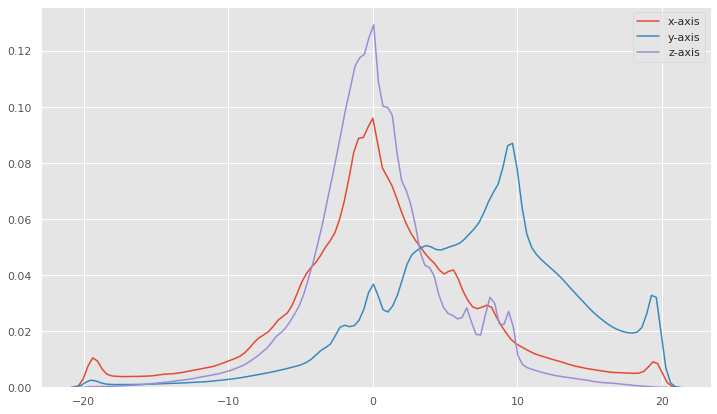

In [0]:
fig= plt.figure(figsize=(12,7))
col = ['x-axis','y-axis','z-axis']
for i in col:
    sns.kdeplot(df[i])
plt.show()

## __III. MODELING__

### 3.2 NEURAL NETWORK

#### PREPROCESSING FOR NN MODELS

____
#### Train_test_split

__Question:__ Split by which method? Whether split by:

*   user-id
*   OR randomly_split (train_test_split method)+ startify sampling

Since some users only have one or two activities and our data set is imbalance, splitting by users may bring us to trouble as we dont have enough samples for each activity in training, validation and test set. Therefore, I decide to use train_test split, shuffle and stratify sampling.  
___

***the data has a 20 Hz sampling rate. if we take 200 steps this equals to 10 second time intervals (calculation: 0.05 * 200 = 10)**

In [0]:
# 10s interval for 200 training example
time_steps = 200
# 20 samples/second
step = 20

In [0]:
#def create_segments_and_labels(df, time_steps, step, label):
    
    # x, y, z acceleration as features
    n_features = 3
    # Each generated sequence contains 200 training examples
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in each segment
        label = stats.mode(df['activity'][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, n_features)
    #labels =np.asarray(pd.get_dummies(labels), dtype = np.float32)

    #return reshaped_segments, labels

In [0]:
# Check shape: (len(df)/time_steps, time_steps,n_features)
print(reshaped_segments.shape)

# Check labels
labels[1]

(54901, 200, 3)


'Jogging'

__SPLIT DATA - USING STRATIFY SAMPLING__

In [0]:
from sklearn.model_selection import train_test_split
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(reshaped_segments, labels, test_size=0.25, stratify=labels, random_state=911)

In [0]:
print(X_train_res.shape, len(y_train_res))
print(X_test_res.shape, len(y_test_res))

(41175, 200, 3) 41175
(13726, 200, 3) 13726


In [0]:
stratify = {
    'total': pd.Series(labels),
    'train': pd.Series(y_train_res),
    'test': pd.Series(y_test_res)
}

pd.DataFrame(stratify).apply(pd.value_counts).apply(lambda col: col/col.sum()*100)

total  train  test
Walking      38.7   38.7  38.7
Jogging      31.2   31.1  31.2
Upstairs     11.2   11.2  11.2
Downstairs    9.2    9.2   9.2
Sitting       5.5    5.5   5.5
Standing      4.4    4.4   4.4

In [0]:
# For data augmentation
X_train_aug = X_train_res
X_test_aug = X_test_res
y_train_aug = y_train_res
y_test_aug = y_test_res

#### Reshape Data

In [0]:
# Enconding y label
y_train_res =np.asarray(pd.get_dummies(y_train_res), dtype = np.float32)
y_test_res =np.asarray(pd.get_dummies(y_test_res), dtype = np.float32)
print('X_train shape: ', X_train_res.shape)
print(X_train_res.shape[0], 'training samples')
print('y_train shape: ', y_train_res.shape)

# Set input & output dimensions
num_time_periods, num_sensors = X_train_res.shape[1], X_train_res.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

X_train shape:  (41175, 200, 3)
41175 training samples
y_train shape:  (41175, 6)
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [0]:
# Input_Shape
input_shape = (num_time_periods*num_sensors)
print('input_shape:', input_shape)

X_train_val = X_train_res.reshape(X_train_res.shape[0], input_shape)
X_test_val = X_test_res.reshape(X_test_res.shape[0], input_shape)
X_train_val= X_train_val.astype('float32')
y_train_val = y_train_res.astype('float32')
X_test_val = X_test_val.astype('float32')
y_test_val = y_test_res.astype('float32')

print('x_train shape:', X_train_res.shape)
print('x_train_val shape:', X_train_val.shape)
print('x_test_val shape:', X_test_val.shape)
print('y_train shape:', y_train_val.shape)
print('y_test shape:', y_test_val.shape)

input_shape: 600
x_train shape: (41175, 200, 3)
x_train_val shape: (41175, 600)
x_test_val shape: (13726, 600)
y_train shape: (41175, 6)
y_test shape: (13726, 6)


In [0]:
callbacks_list = [keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True), keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

# Hyper-parameters
batch_size = 1024
epochs = 50

___
### 3.2.1 DNN (MLP)
- First Neural Network model: using Feed-Foward Perceptrons with 3 dense layers stacked on top of each other
- Remark: since coreml cannot accept vector shapes of complex shape like
[200,3] this workaround is used in order to reshape the vector internally prior feeding it into the network
___

In [0]:
def make_bare_dnn_model(n_neurons):
  model = Sequential()
  model.add(Reshape((time_steps, 3), input_shape=(input_shape,)))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

___
#### DNN ( 3 dense layers, n_neurons/layer: 100)
___

In [0]:
model_dnn = make_bare_dnn_model(n_neurons = 100)
print(model_dnn.summary())






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 200, 3)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 200, 100)          400       
_________________________________________________________________
dense_2 (Dense)              (None, 200, 100)          10100     
_________________________________________________________________
dense_3 (Dense)              (None, 200, 100)          10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 120006    
Total params: 140,606
Trainable params: 140,606
Non-trainable params: 0
___________________________________________

In [0]:
X_train_res.shape

(41175, 200, 3)

In [0]:
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
DNN = model_dnn.fit(X_train_val, y_train_val, batch_size=batch_size, epochs=epochs,
                      callbacks=callbacks_list, validation_split=0.2, verbose=1)

x_train shape: (41175, 600)
y_train shape: (41175, 6)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 32940 samples, validate on 8235 samples
Epoch 1/50





32940/32940 [==============================] - 2s 64us/step - loss: 1.2319 - acc: 0.6573 - val_loss: 0.6384 - val_acc: 0.7736
Epoch 2/50
32940/32940 [==============================] - 1s 25us/step - loss: 0.5594 - acc: 0.7987 - val_loss: 0.5320 - val_acc: 0.8115
Epoch 3/50
32940/32940 [==============================] - 1s 24us/step - loss: 0.4842 - acc: 0.8264 - val_loss: 0.5071 - val_acc: 0.8197
Epoch 4/50
32940/32940 [==============================] - 1s 24us/step - loss: 0.4434 - acc: 0.8383 - val_loss: 0.4728 - val_acc: 0.8290
Epoch 5/50
32940/32940 [==============================] - 1s 24us/step - loss: 0.4006 - acc: 0.8535 - val_loss: 0.4724 - val_acc: 0.8253
Epoch 6/50
32940/32940 [==============================] - 1s 24us/step - loss: 0.3730 - acc: 0.8610 - val_loss

In [0]:
def plot(model):
  plt.figure(figsize=(18, 7))
  plt.plot(model.history['acc'], 'g--', label='Accuracy of training data')
  plt.plot(model.history['val_acc'], 'g', label='Accuracy of validation data')
  plt.plot(model.history['loss'], 'r--', label='Loss of training data')
  plt.plot(model.history['val_loss'], 'r', label='Loss of validation data')
  plt.title('Model Accuracy and Loss')
  plt.legend(loc='upper right', shadow=True)
  plt.ylabel('Training Progress (Loss or Accuracy values)')
  plt.xlabel('Training Epoch')
  plt.ylim(0)
  plt.legend()
  plt.show()

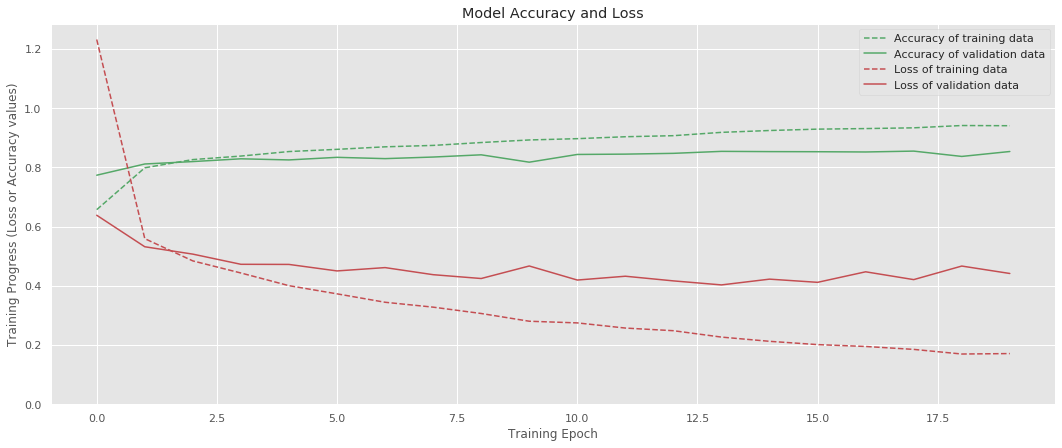

              precision    recall  f1-score   support

           0       0.87      0.62      0.73      3773
           1       0.99      0.99      0.99     12826
           2       1.00      1.00      1.00      2245
           3       1.00      1.00      1.00      1814
           4       0.82      0.76      0.79      4600
           5       0.90      0.98      0.94     15917

    accuracy                           0.93     41175
   macro avg       0.93      0.89      0.91     41175
weighted avg       0.93      0.93      0.92     41175



In [0]:
plot(DNN)

# Print confusion matrix for training data
y_pred_train = model_dnn.predict(X_train_val)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
max_train = np.argmax(y_train_res, axis=1)
print(classification_report(max_train, max_y_pred_train))

__COMMENT:__
- Since this is an imbalance data set, looking at the accuracy would be misleading. We should rather look at the precision, recall and f1-socre across the classes
- Sign of overfitting, validation loss increases & there is gap between training and test (0.93 vs.0.86 respectively)

In [0]:
score = model_dnn.evaluate(X_test_val, y_test_val, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

13726/13726 [==============================] - 1s 47us/step

Accuracy on test data: 0.86

Loss on test data: 0.44


In [0]:
def confusion_matrix(y, y_pred):
    labels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
    matrix = metrics.confusion_matrix(y, y_pred)
    plt.figure(figsize=(9, 6))
    ax= sns.heatmap(matrix, cmap='coolwarm', linecolor='white', linewidths=1, xticklabels=labels, yticklabels=labels, annot=True, fmt='d')
    #bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

              precision    recall  f1-score   support

           0       0.63      0.41      0.50      1258
           1       0.97      0.96      0.96      4276
           2       0.99      0.97      0.98       749
           3       0.98      0.98      0.98       604
           4       0.62      0.52      0.56      1533
           5       0.83      0.96      0.89      5306

    accuracy                           0.86     13726
   macro avg       0.84      0.80      0.81     13726
weighted avg       0.85      0.86      0.85     13726



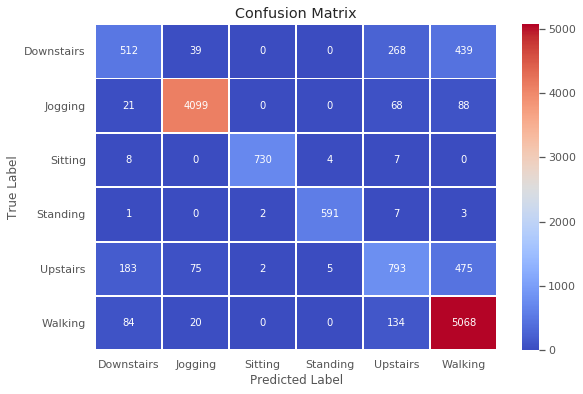

In [0]:
# Take the class with the highest probability from the test predictions
y_pred_test = model_dnn.predict(X_test_val)
max_y_pred_test = np.argmax(y_pred_test, axis = 1)
max_y_test = np.argmax(y_test_val, axis = 1)

#confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))
confusion_matrix(max_y_test, max_y_pred_test)

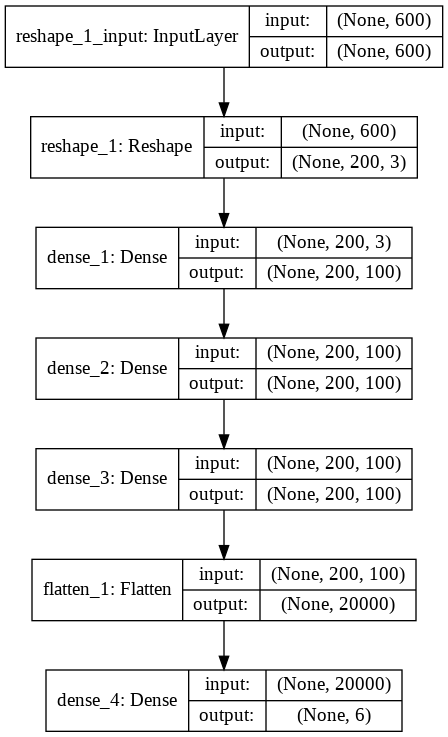

In [0]:
from keras.utils import plot_model
plot_model(model_dnn, show_shapes=True, to_file='model_dnn_100.png')

___
#### DNN ( 3 dense layers, n_neurons/layer: 64)
___



In [0]:
model_dnn_64 = make_bare_dnn_model(n_neurons = 64)
print(model_dnn_64.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 200, 3)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 200, 64)           256       
_________________________________________________________________
dense_6 (Dense)              (None, 200, 64)           4160      
_________________________________________________________________
dense_7 (Dense)              (None, 200, 64)           4160      
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 76806     
Total params: 85,382
Trainable params: 85,382
Non-trainable params: 0
__________________________________________________

In [0]:
DNN_64 = model_dnn_64.fit(X_train_val,
                      y_train_val,
                      batch_size=batch_size,
                      epochs=epochs,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 32940 samples, validate on 8235 samples
Epoch 1/50
32940/32940 [==============================] - 1s 26us/step - loss: 1.1003 - acc: 0.6439 - val_loss: 0.6574 - val_acc: 0.7711
Epoch 2/50
32940/32940 [==============================] - 0s 15us/step - loss: 0.5768 - acc: 0.7945 - val_loss: 0.5430 - val_acc: 0.8044
Epoch 3/50
32940/32940 [==============================] - 0s 15us/step - loss: 0.4952 - acc: 0.8218 - val_loss: 0.5191 - val_acc: 0.8149
Epoch 4/50
32940/32940 [==============================] - 1s 15us/step - loss: 0.4439 - acc: 0.8386 - val_loss: 0.4822 - val_acc: 0.8249
Epoch 5/50
32940/32940 [==============================] - 0s 15us/step - loss: 0.3994 - acc: 0.8532 - val_loss: 0.4580 - val_acc: 0.8285
Epoch 6/50
32940/32940 [==============================] - 0s 15us/step - loss: 0.3704 - acc: 0.8603 - val_loss: 0.4395 - val_acc: 0.8340
Epoch 7/50
32940/32940 [==============================] - 1s 15us/step - loss: 0.3439 - acc: 0.8689 - val_loss: 0.4545 - val_acc:

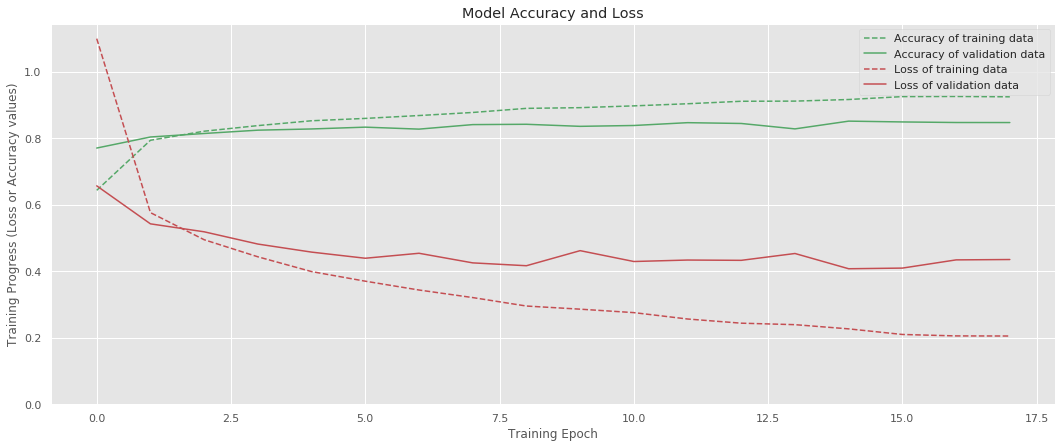

              precision    recall  f1-score   support

           0       0.86      0.58      0.69      3773
           1       0.99      0.99      0.99     12826
           2       1.00      0.96      0.98      2245
           3       0.95      1.00      0.97      1814
           4       0.66      0.89      0.76      4600
           5       0.95      0.92      0.93     15917

    accuracy                           0.91     41175
   macro avg       0.90      0.89      0.89     41175
weighted avg       0.92      0.91      0.91     41175



In [0]:
plot(DNN_64)

# Print confusion matrix for training data
y_pred_train = model_dnn_64.predict(X_train_val)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
max_train = np.argmax(y_train_res, axis=1)
print(classification_report(max_train, max_y_pred_train))

In [0]:
score = model_dnn_64.evaluate(X_test_val, y_test_val, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

13726/13726 [==============================] - 1s 45us/step

Accuracy on test data: 0.85

Loss on test data: 0.43


              precision    recall  f1-score   support

           0       0.61      0.37      0.46      1258
           1       0.96      0.97      0.96      4276
           2       0.99      0.93      0.96       749
           3       0.93      0.98      0.95       604
           4       0.52      0.69      0.59      1533
           5       0.89      0.88      0.88      5306

    accuracy                           0.85     13726
   macro avg       0.82      0.80      0.80     13726
weighted avg       0.85      0.85      0.84     13726



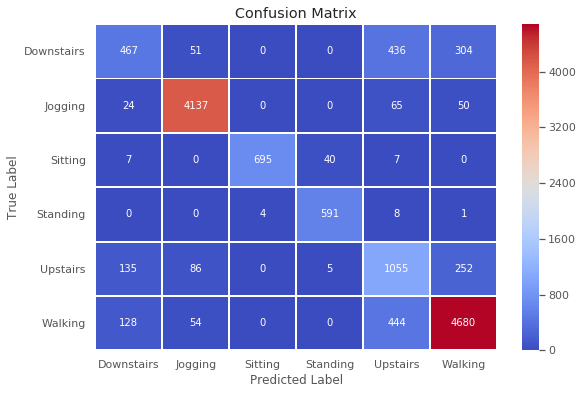

In [0]:
# Take the class with the highest probability from the test predictions
y_pred_test = model_dnn_64.predict(X_test_val)
max_y_pred_test = np.argmax(y_pred_test, axis = 1)
max_y_test = np.argmax(y_test_val, axis = 1)

#confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))
confusion_matrix(max_y_test, max_y_pred_test)

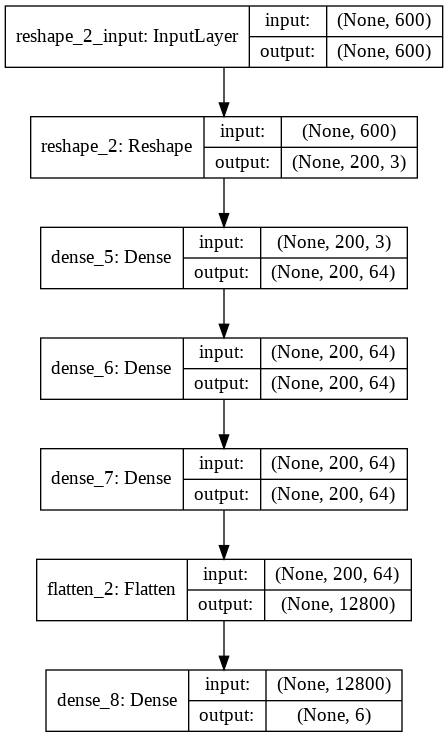

In [0]:
from keras.utils import plot_model
plot_model(model_dnn_64, show_shapes=True, to_file='model_dnn_64.png')

___
### 3.2.2 LSTM + Dense
___

In [0]:
def make_lstm_dense_model(lstm_neurons, dense_neurons, drop_out):
  model = Sequential()
  model.add(Reshape((time_steps, 3), input_shape=(input_shape,)))
  model.add(LSTM(lstm_neurons, input_shape=(input_shape,)))
  model.add(Dropout(drop_out))
  model.add(Dense(dense_neurons, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

___
#### LSTM:100 + Dropout: 0.5 + Dense: 100

Model defined as having a single LSTM hidden layer, following by a dropout layer intended to reduce overfitting. Then, add in a dense fully connected layer to interpret the features extracted by the LSTM hidden layer, before a final output layer is used to make predictions.
___

In [0]:
model_lstm_dense_100 = make_lstm_dense_model(lstm_neurons= 100, dense_neurons= 100, drop_out= 0.5)
print(model_lstm_dense_100.summary())


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 200, 3)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 606       
Total params: 52,306
Trainable params: 52,306
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm_dense_100 = model_lstm_dense_100.fit(X_train_val, y_train_val, batch_size=batch_size,
                      epochs=epochs, callbacks=callbacks_list, validation_split=0.2,verbose=1)

Train on 32940 samples, validate on 8235 samples
Epoch 1/50
32940/32940 [==============================] - 12s 352us/step - loss: 1.4161 - acc: 0.4263 - val_loss: 1.0849 - val_acc: 0.5840
Epoch 2/50
32940/32940 [==============================] - 11s 325us/step - loss: 0.8344 - acc: 0.7049 - val_loss: 0.6472 - val_acc: 0.7785
Epoch 3/50
32940/32940 [==============================] - 11s 328us/step - loss: 0.5948 - acc: 0.7955 - val_loss: 0.5202 - val_acc: 0.8145
Epoch 4/50
32940/32940 [==============================] - 11s 325us/step - loss: 0.5075 - acc: 0.8183 - val_loss: 0.4655 - val_acc: 0.8330
Epoch 5/50
32940/32940 [==============================] - 11s 328us/step - loss: 0.4649 - acc: 0.8279 - val_loss: 0.4490 - val_acc: 0.8389
Epoch 6/50
32940/32940 [==============================] - 11s 329us/step - loss: 0.4229 - acc: 0.8410 - val_loss: 0.3776 - val_acc: 0.8545
Epoch 7/50
32940/32940 [==============================] - 11s 325us/step - loss: 0.3914 - acc: 0.8508 - val_loss: 0.3

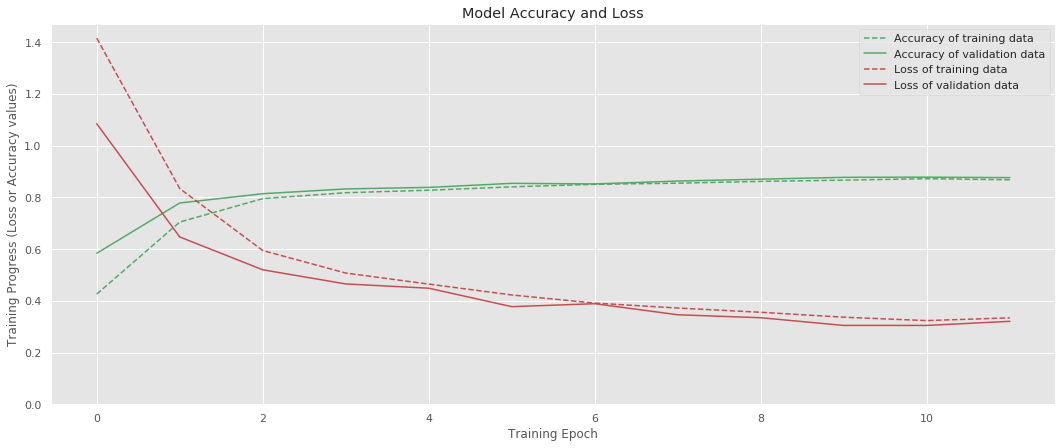

              precision    recall  f1-score   support

           0       0.59      0.51      0.55      3773
           1       0.97      0.98      0.98     12826
           2       0.98      0.89      0.93      2245
           3       0.90      0.96      0.93      1814
           4       0.58      0.57      0.58      4600
           5       0.92      0.96      0.94     15917

    accuracy                           0.88     41175
   macro avg       0.83      0.81      0.82     41175
weighted avg       0.87      0.88      0.88     41175



In [0]:
plot(lstm_dense_100)

# Print confusion matrix for training data
y_pred_train = model_lstm_dense_100.predict(X_train_val)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
max_train = np.argmax(y_train_res, axis=1)
print(classification_report(max_train, max_y_pred_train))

In [0]:
score = model_lstm_dense_100.evaluate(X_test_val, y_test_val, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

13726/13726 [==============================] - 48s 3ms/step

Accuracy on test data: 0.88

Loss on test data: 0.33


              precision    recall  f1-score   support

           0       0.58      0.50      0.54      1258
           1       0.97      0.98      0.97      4276
           2       0.98      0.88      0.92       749
           3       0.88      0.97      0.92       604
           4       0.60      0.55      0.57      1533
           5       0.92      0.96      0.94      5306

    accuracy                           0.88     13726
   macro avg       0.82      0.81      0.81     13726
weighted avg       0.87      0.88      0.87     13726



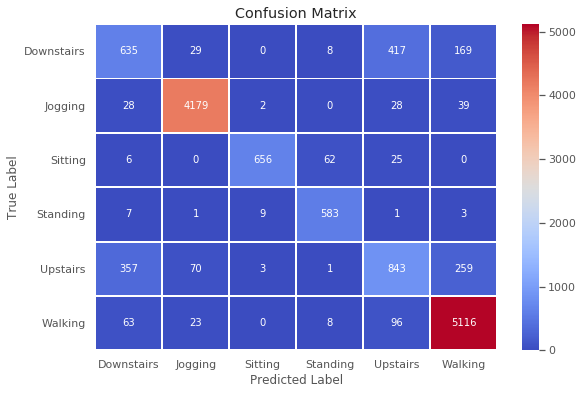

In [0]:
# Take the class with the highest probability from the test predictions
y_pred_test = model_lstm_dense_100.predict(X_test_val)
max_y_pred_test = np.argmax(y_pred_test, axis = 1)
max_y_test = np.argmax(y_test_val, axis = 1)

#confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))
confusion_matrix(max_y_test, max_y_pred_test)

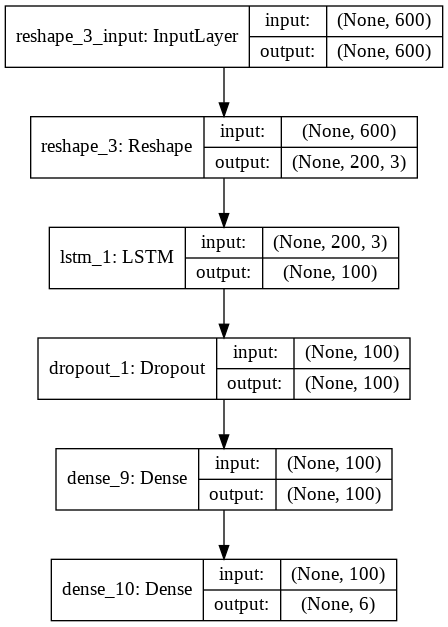

In [0]:
from keras.utils import plot_model
plot_model(model_lstm_dense_100, show_shapes=True, to_file='model_lstm_dense_100.png')

___
#### LSTM:64 + Dropout: 0.5 + Dense: 64
___

In [0]:
model_lstm_dense_64 = make_lstm_dense_model(lstm_neurons= 64, dense_neurons= 64, drop_out= 0.5)
print(model_lstm_dense_64.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 200, 3)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                17408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 390       
Total params: 21,958
Trainable params: 21,958
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
lstm_dense_64 = model_lstm_dense_64.fit(X_train_val, y_train_val, batch_size=batch_size,
                      epochs=epochs, callbacks=callbacks_list, validation_split=0.2,verbose=1)

Train on 32940 samples, validate on 8235 samples
Epoch 1/50
32940/32940 [==============================] - 12s 353us/step - loss: 1.5192 - acc: 0.3702 - val_loss: 1.1999 - val_acc: 0.5191
Epoch 2/50
32940/32940 [==============================] - 10s 317us/step - loss: 1.0161 - acc: 0.6090 - val_loss: 0.7256 - val_acc: 0.7615
Epoch 3/50
32940/32940 [==============================] - 11s 320us/step - loss: 0.7081 - acc: 0.7531 - val_loss: 0.6373 - val_acc: 0.7803
Epoch 4/50
32940/32940 [==============================] - 11s 322us/step - loss: 0.6245 - acc: 0.7801 - val_loss: 0.5823 - val_acc: 0.7979
Epoch 5/50
32940/32940 [==============================] - 10s 317us/step - loss: 0.5842 - acc: 0.7942 - val_loss: 0.5486 - val_acc: 0.8100
Epoch 6/50
32940/32940 [==============================] - 11s 321us/step - loss: 0.5454 - acc: 0.8098 - val_loss: 0.5184 - val_acc: 0.8141
Epoch 7/50
32940/32940 [==============================] - 10s 318us/step - loss: 0.5352 - acc: 0.8160 - val_loss: 0.5

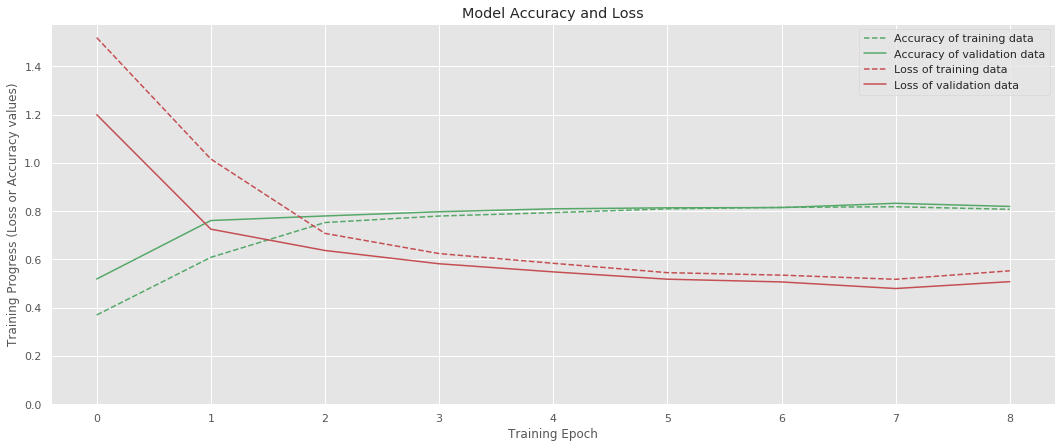

              precision    recall  f1-score   support

           0       0.50      0.44      0.47      3773
           1       0.90      0.98      0.94     12826
           2       0.97      0.88      0.92      2245
           3       0.86      0.95      0.90      1814
           4       0.51      0.39      0.44      4600
           5       0.87      0.89      0.88     15917

    accuracy                           0.82     41175
   macro avg       0.77      0.75      0.76     41175
weighted avg       0.81      0.82      0.81     41175



In [0]:
plot(lstm_dense_64)

# Print confusion matrix for training data
y_pred_train = model_lstm_dense_64.predict(X_train_val)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
max_train = np.argmax(y_train_res, axis=1)
print(classification_report(max_train, max_y_pred_train))

In [0]:
score = model_lstm_dense_64.evaluate(X_test_val, y_test_val, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

13726/13726 [==============================] - 48s 3ms/step

Accuracy on test data: 0.82

Loss on test data: 0.51


              precision    recall  f1-score   support

           0       0.49      0.44      0.46      1258
           1       0.90      0.97      0.94      4276
           2       0.96      0.87      0.91       749
           3       0.84      0.94      0.89       604
           4       0.50      0.37      0.43      1533
           5       0.86      0.89      0.88      5306

    accuracy                           0.82     13726
   macro avg       0.76      0.75      0.75     13726
weighted avg       0.81      0.82      0.81     13726



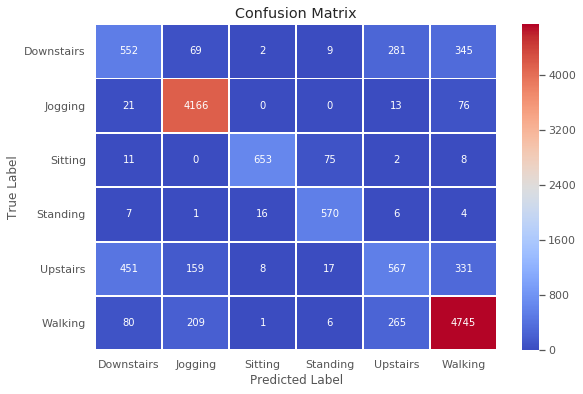

In [0]:
# Take the class with the highest probability from the test predictions
y_pred_test = model_lstm_dense_64.predict(X_test_val)
max_y_pred_test = np.argmax(y_pred_test, axis = 1)
max_y_test = np.argmax(y_test_val, axis = 1)

#confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))
confusion_matrix(max_y_test, max_y_pred_test)

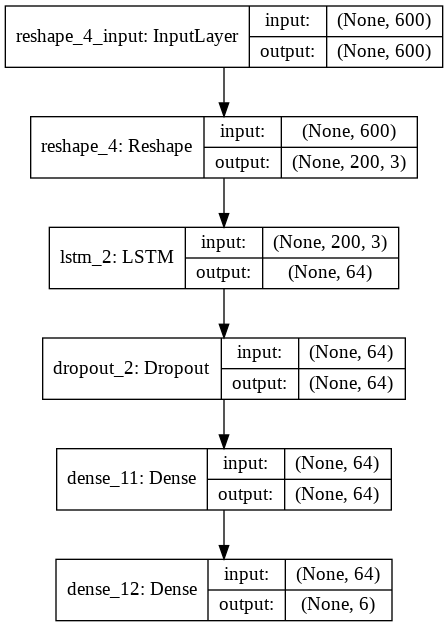

In [0]:
plot_model(model_lstm_dense_64, show_shapes=True, to_file='model_lstm_dense_64.png')

___
### 3.2.3 LSTM stack 3 layers


*   __Took more time than other models to train and fit__
*   return_sequences = True: access the hidden state output for each input time step
*   return_state = True: access to the the cell state
*   batch_input_shape defines that the sequential classification of the neural network can accept input data of the defined only batch size, restricting in that way the creation of any variable dimension vector.
*   A stateful recurrent model is one for which the internal states (memories) obtained after processing a batch of samples are reused as initial states for the samples of the next batch. This allows to process longer sequences while keeping computational complexity manageable.
*   If `stateful=True`, then the output state for sample $i$ in a batch will be used as initial state for the corresponding sample $i$ in the next batch, i.e. states computed for the samples in one batch will be reused as initial states for the corresponding samples in the next batch. This assumes a one-to-one mapping between samples in different successive batches.
*   Statful model requires specification of parameter `batch_input_shape` and setting `shuffle=False` when calling `fit`.
*   In stateful layer internal state resets only "manually" by using `reset_state()`. Stateless layer will reset internal state after each batch.
___

#### LSTM: 100, batch_size = 915

In [0]:
def make_lstm_stack_model(lstm_neurons):
  model = Sequential()
  model.add(LSTM(lstm_neurons, return_sequences=True, stateful = True,
                 batch_input_shape=(batch_size, 200, 3)))
  model.add(LSTM(lstm_neurons, return_sequences=True, stateful = True))
  model.add(LSTM(lstm_neurons, stateful = True))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
batch_size = 915
model_lstm_stack_100 = make_lstm_stack_model(lstm_neurons= 100)
print(model_lstm_stack_100.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (915, 200, 100)           41600     
_________________________________________________________________
lstm_4 (LSTM)                (915, 200, 100)           80400     
_________________________________________________________________
lstm_5 (LSTM)                (915, 100)                80400     
_________________________________________________________________
dense_13 (Dense)             (915, 6)                  606       
Total params: 203,006
Trainable params: 203,006
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
lstm_stack_100 = model_lstm_stack_100.fit(X_train_res, y_train_val, batch_size=batch_size,
                      epochs=epochs, callbacks=callbacks_list, validation_split=0.2,verbose=1)

Train on 32940 samples, validate on 8235 samples
Epoch 1/50
32940/32940 [==============================] - 31s 932us/step - loss: 1.1399 - acc: 0.5571 - val_loss: 0.7048 - val_acc: 0.7583
Epoch 2/50
32940/32940 [==============================] - 29s 873us/step - loss: 0.6083 - acc: 0.7864 - val_loss: 0.5280 - val_acc: 0.8095
Epoch 3/50
32940/32940 [==============================] - 29s 873us/step - loss: 0.4942 - acc: 0.8175 - val_loss: 0.4814 - val_acc: 0.8232
Epoch 4/50
32940/32940 [==============================] - 29s 875us/step - loss: 0.4534 - acc: 0.8322 - val_loss: 0.4173 - val_acc: 0.8438
Epoch 5/50
32940/32940 [==============================] - 29s 878us/step - loss: 0.3852 - acc: 0.8508 - val_loss: 0.3800 - val_acc: 0.8536
Epoch 6/50
32940/32940 [==============================] - 29s 874us/step - loss: 0.3600 - acc: 0.8602 - val_loss: 0.3417 - val_acc: 0.8655
Epoch 7/50
32940/32940 [==============================] - 29s 881us/step - loss: 0.3343 - acc: 0.8672 - val_loss: 0.3

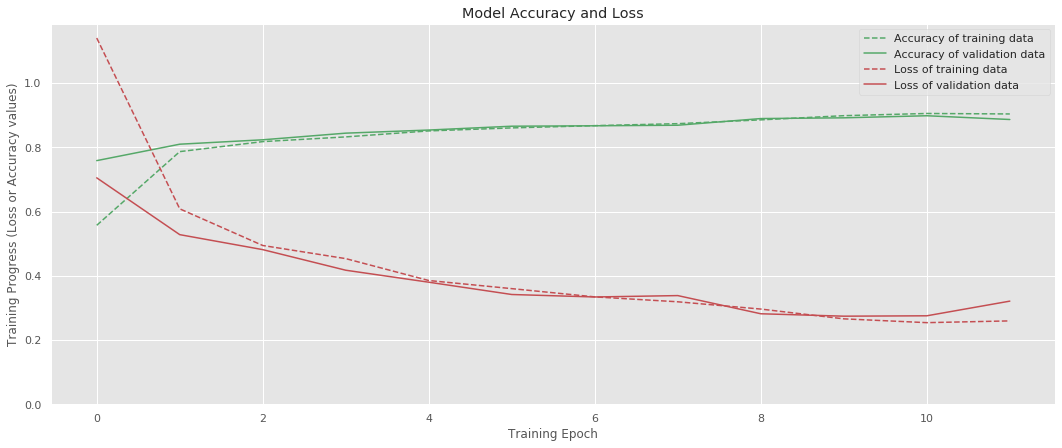

              precision    recall  f1-score   support

           0       0.69      0.66      0.68      3773
           1       0.97      0.98      0.97     12826
           2       0.98      0.90      0.94      2245
           3       0.90      0.96      0.92      1814
           4       0.74      0.57      0.64      4600
           5       0.90      0.97      0.93     15917

    accuracy                           0.89     41175
   macro avg       0.86      0.84      0.85     41175
weighted avg       0.89      0.89      0.89     41175



In [0]:
plot(lstm_stack_100)

# Print confusion matrix for training data
y_pred_train = model_lstm_stack_100.predict(X_train_res, batch_size=batch_size)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
max_train = np.argmax(y_train_res, axis=1)
print(classification_report(max_train, max_y_pred_train))

__Since the batch_size = 915, which can not fit the model with such a batch_size to the test set with 13726 samples, we remove 1 samples from test data__

In [0]:
y_test_trimmed = y_test_val
y_test_trimmed = np.delete(y_test_trimmed, (13725), axis=0)
y_test_trimmed.shape

(13725, 6)

In [0]:
X_test_trimmed = X_test_res
X_test_trimmed = np.delete(X_test_trimmed, (13725), axis=0)
X_test_trimmed.shape

(13725, 200, 3)

In [0]:
score = model_lstm_stack_100.evaluate(X_test_trimmed, y_test_trimmed, verbose=1, batch_size=batch_size)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

13725/13725 [==============================] - 5s 350us/step

Accuracy on test data: 0.89

Loss on test data: 0.32


              precision    recall  f1-score   support

           0       0.69      0.66      0.67      1258
           1       0.97      0.98      0.97      4276
           2       0.97      0.89      0.93       749
           3       0.90      0.94      0.92       604
           4       0.74      0.56      0.64      1533
           5       0.89      0.96      0.93      5305

    accuracy                           0.89     13725
   macro avg       0.86      0.83      0.84     13725
weighted avg       0.88      0.89      0.88     13725



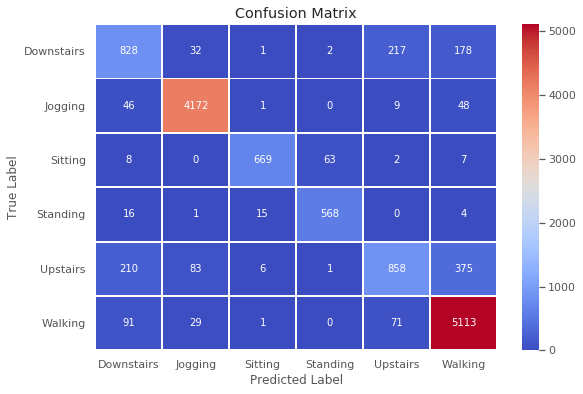

In [0]:
# Take the class with the highest probability from the test predictions
y_pred_test = model_lstm_stack_100.predict(X_test_trimmed, batch_size=batch_size)
max_y_pred_test = np.argmax(y_pred_test, axis = 1)
max_y_test = np.argmax(y_test_trimmed, axis = 1)

#confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))
confusion_matrix(max_y_test, max_y_pred_test)

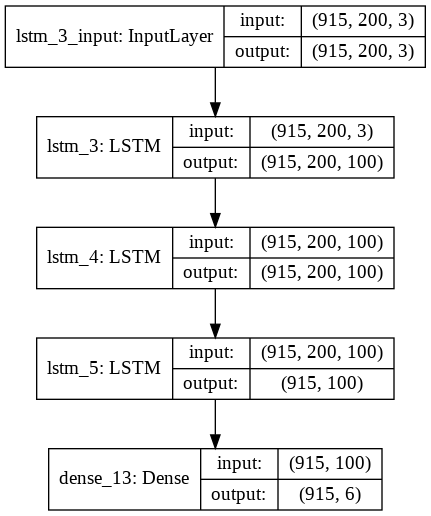

In [0]:
plot_model(model_lstm_stack_100, show_shapes=True, to_file='model_lstm_stack_100.png')

___
### 3.2.4 CNN-LSTM and ConvLSTM


___
#### CNN-LSTM
- CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.
- CNN LSTM model will read subsequences of the main sequence in as blocks, extract features from each block, then allow the LSTM to interpret the features extracted from each block.
- CNN LSTM interprets the output from CNN models
- It is common to use two consecutive CNN layers followed by dropout and a max pooling layer
___

In [0]:
def make_cnn_lstm_model(lstm_neurons,dense_neurons,drop_out):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), 
                            input_shape=(None,n_length,n_features)))
  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
  model.add(TimeDistributed(Dropout(drop_out)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(lstm_neurons))
  model.add(Dropout(drop_out)) 
  model.add(Dense(dense_neurons, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 20, 10
X_train_cnn = X_train_res.reshape((X_train_res.shape[0], n_steps, n_length, n_features))
X_test_cnn = X_test_res.reshape((X_test_res.shape[0], n_steps, n_length, n_features))

In [0]:
model_cnn_lstm = make_cnn_lstm_model(lstm_neurons= 100, dense_neurons = 100, drop_out = 0.5)
print(model_cnn_lstm.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 8, 64)       640       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 6, 64)       12352     
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 6, 64)       0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 3, 64)       0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 192)         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               117200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)              

In [0]:
batch_size = 1024
epochs = 50
cnn_lstm = model_cnn_lstm.fit(X_train_cnn, y_train_val, batch_size=batch_size,
                      epochs=epochs, callbacks=callbacks_list, validation_split=0.2,verbose=1)

Train on 32940 samples, validate on 8235 samples
Epoch 1/50
32940/32940 [==============================] - 4s 124us/step - loss: 0.9966 - acc: 0.6423 - val_loss: 0.5844 - val_acc: 0.7960
Epoch 2/50
32940/32940 [==============================] - 2s 59us/step - loss: 0.5150 - acc: 0.8134 - val_loss: 0.4225 - val_acc: 0.8380
Epoch 3/50
32940/32940 [==============================] - 2s 58us/step - loss: 0.4182 - acc: 0.8426 - val_loss: 0.3360 - val_acc: 0.8697
Epoch 4/50
32940/32940 [==============================] - 2s 57us/step - loss: 0.3553 - acc: 0.8639 - val_loss: 0.3155 - val_acc: 0.8801
Epoch 5/50
32940/32940 [==============================] - 2s 58us/step - loss: 0.3058 - acc: 0.8849 - val_loss: 0.2419 - val_acc: 0.9107
Epoch 6/50
32940/32940 [==============================] - 2s 57us/step - loss: 0.2576 - acc: 0.9079 - val_loss: 0.2965 - val_acc: 0.8959
Epoch 7/50
32940/32940 [==============================] - 2s 56us/step - loss: 0.2330 - acc: 0.9179 - val_loss: 0.1766 - val_acc

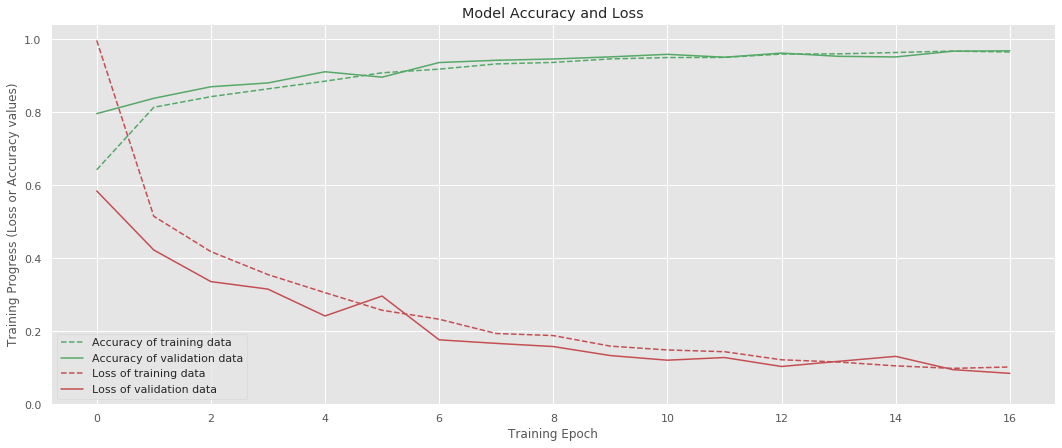

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      3773
           1       0.99      0.99      0.99     12826
           2       0.97      0.97      0.97      2245
           3       0.96      0.96      0.96      1814
           4       0.95      0.88      0.92      4600
           5       1.00      0.99      0.99     15917

    accuracy                           0.97     41175
   macro avg       0.96      0.96      0.96     41175
weighted avg       0.98      0.97      0.97     41175



In [0]:
plot(cnn_lstm)

# Print confusion matrix for training data
y_pred_train = model_cnn_lstm.predict(X_train_cnn, batch_size=batch_size)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
max_train = np.argmax(y_train_res, axis=1)
print(classification_report(max_train, max_y_pred_train))

In [0]:
score = model_cnn_lstm.evaluate(X_test_cnn, y_test_res, verbose=1, batch_size=batch_size)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

13726/13726 [==============================] - 0s 12us/step

Accuracy on test data: 0.97

Loss on test data: 0.09


              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1258
           1       0.99      0.99      0.99      4276
           2       0.96      0.96      0.96       749
           3       0.96      0.95      0.95       604
           4       0.94      0.86      0.90      1533
           5       0.99      0.99      0.99      5306

    accuracy                           0.97     13726
   macro avg       0.95      0.95      0.95     13726
weighted avg       0.97      0.97      0.97     13726



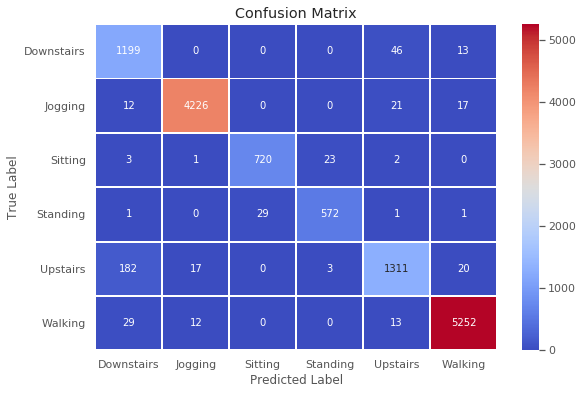

In [0]:
# Take the class with the highest probability from the test predictions
y_pred_test = model_cnn_lstm.predict(X_test_cnn, batch_size=batch_size)
max_y_pred_test = np.argmax(y_pred_test, axis = 1)
max_y_test = np.argmax(y_test_res, axis = 1)

#confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))
confusion_matrix(max_y_test, max_y_pred_test)

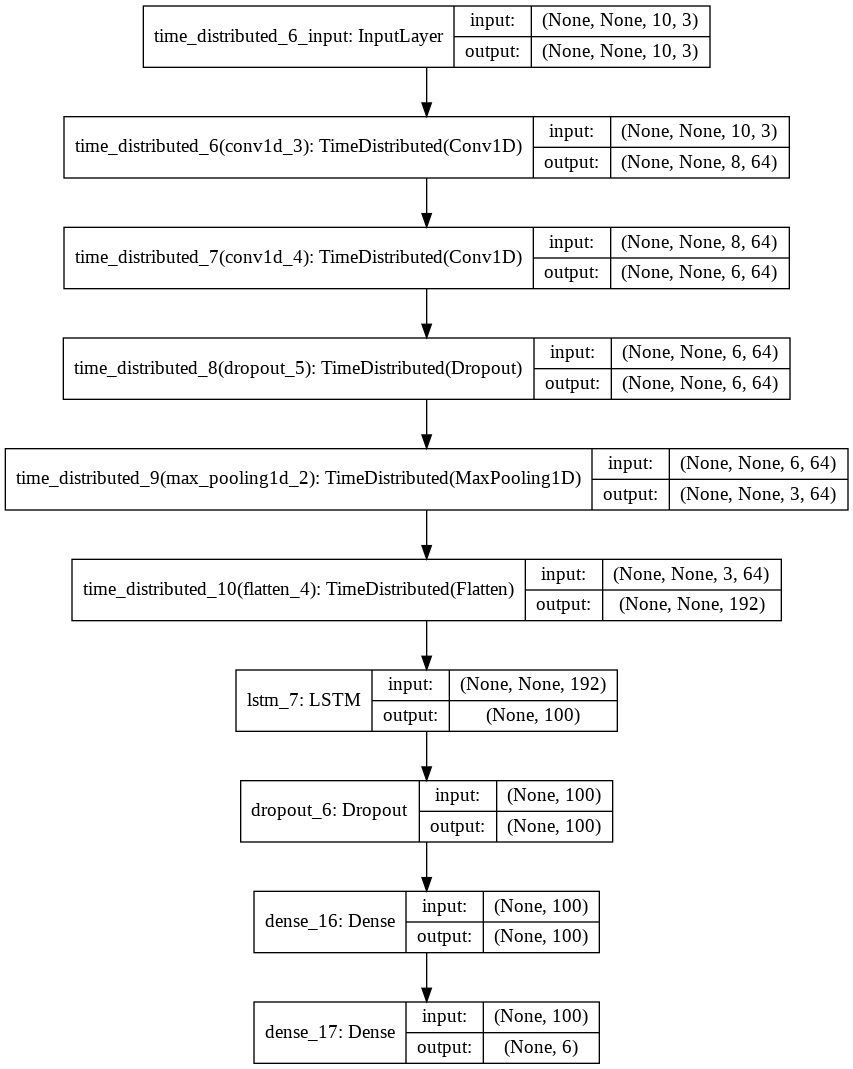

In [0]:
from keras.utils import plot_model
plot_model(model_cnn_lstm, show_shapes=True, to_file='model_cnn_lstm.png')

___
#### ConvLSTM

Unlike the CNN LSTM that is interpreting the output from CNN models, the ConvLSTM is using convolutions directly as part of reading input into the LSTM units themselves.

Input for the ConvLSTM2D would be:

*  Samples: n, for the number of windows in the dataset.
*  Time: 10, for the four subsequences that we split a window of 200 time steps into.
*  Rows: 1, for the one-dimensional shape of each subsequence.
*  Columns: 20, for the 20 time steps in an input subsequence.
*  Channels: 3, for the three input variables.
___

In [0]:
def make_conv_lstm_model(dense_neurons,drop_out):
  model = Sequential()
  model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', 
                       input_shape=(n_steps, 1, n_length, n_features)))
  model.add(Dropout(drop_out))
  model.add(Flatten())
  model.add(Dense(dense_neurons, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
n_timesteps, n_features, n_outputs = X_train_res.shape[1], X_train_res.shape[2], y_train_res.shape[1]
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 20, 10
X_train_conv = X_train_res.reshape((X_train_res.shape[0], n_steps, 1, n_length, n_features))
X_test_conv = X_test_res.reshape((X_test_res.shape[0], n_steps, 1, n_length, n_features))

In [0]:
model_conv_lstm = make_conv_lstm_model(dense_neurons = 100, drop_out = 0.5)
print(model_conv_lstm.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 8, 64)          51712     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 8, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               51300     
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 606       
Total params: 103,618
Trainable params: 103,618
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
batch_size = 1024
epochs = 50
conv_lstm = model_conv_lstm.fit(X_train_conv, y_train_val, batch_size=batch_size,
                      epochs=epochs, callbacks=callbacks_list, validation_split=0.2,verbose=1)

Train on 32940 samples, validate on 8235 samples
Epoch 1/50
32940/32940 [==============================] - 6s 184us/step - loss: 0.9543 - acc: 0.6469 - val_loss: 0.6116 - val_acc: 0.7546
Epoch 2/50
32940/32940 [==============================] - 3s 106us/step - loss: 0.5411 - acc: 0.7985 - val_loss: 0.4433 - val_acc: 0.8347
Epoch 3/50
32940/32940 [==============================] - 3s 106us/step - loss: 0.4239 - acc: 0.8408 - val_loss: 0.3629 - val_acc: 0.8614
Epoch 4/50
32940/32940 [==============================] - 3s 104us/step - loss: 0.3714 - acc: 0.8582 - val_loss: 0.3230 - val_acc: 0.8740
Epoch 5/50
32940/32940 [==============================] - 4s 107us/step - loss: 0.3279 - acc: 0.8735 - val_loss: 0.2878 - val_acc: 0.8856
Epoch 6/50
32940/32940 [==============================] - 4s 107us/step - loss: 0.3119 - acc: 0.8809 - val_loss: 0.2598 - val_acc: 0.9005
Epoch 7/50
32940/32940 [==============================] - 4s 107us/step - loss: 0.2648 - acc: 0.8990 - val_loss: 0.2289 - v

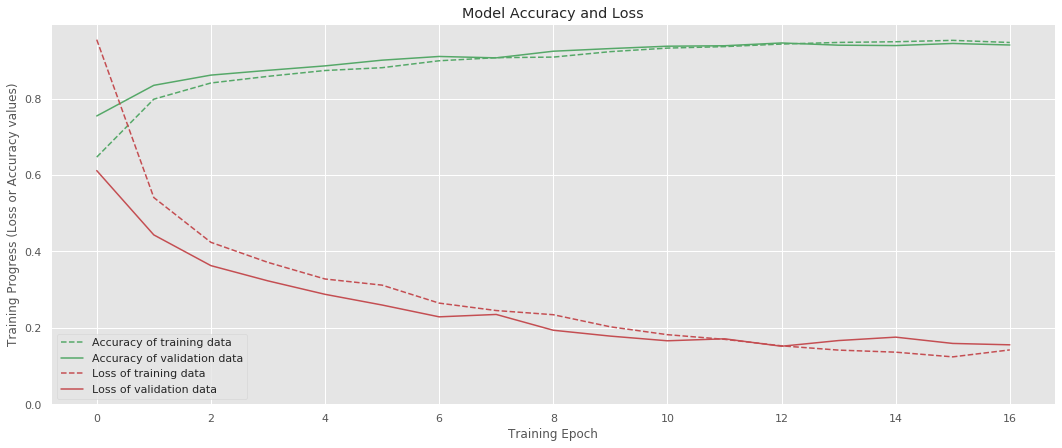

              precision    recall  f1-score   support

           0       0.94      0.61      0.74      3773
           1       1.00      0.98      0.99     12826
           2       0.99      0.98      0.98      2245
           3       0.98      0.98      0.98      1814
           4       0.75      0.95      0.84      4600
           5       0.97      0.99      0.98     15917

    accuracy                           0.95     41175
   macro avg       0.94      0.91      0.92     41175
weighted avg       0.95      0.95      0.95     41175



In [0]:
plot(conv_lstm)

# Print confusion matrix for training data
y_pred_train = model_conv_lstm.predict(X_train_conv, batch_size=batch_size)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
max_train = np.argmax(y_train_res, axis=1)
print(classification_report(max_train, max_y_pred_train))

In [0]:
score = model_conv_lstm.evaluate(X_test_conv, y_test_res, verbose=1, batch_size=batch_size)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

13726/13726 [==============================] - 0s 24us/step

Accuracy on test data: 0.94

Loss on test data: 0.16


              precision    recall  f1-score   support

           0       0.92      0.59      0.72      1258
           1       1.00      0.98      0.99      4276
           2       0.99      0.97      0.98       749
           3       0.96      0.97      0.97       604
           4       0.73      0.93      0.82      1533
           5       0.96      0.99      0.97      5306

    accuracy                           0.94     13726
   macro avg       0.93      0.90      0.91     13726
weighted avg       0.95      0.94      0.94     13726



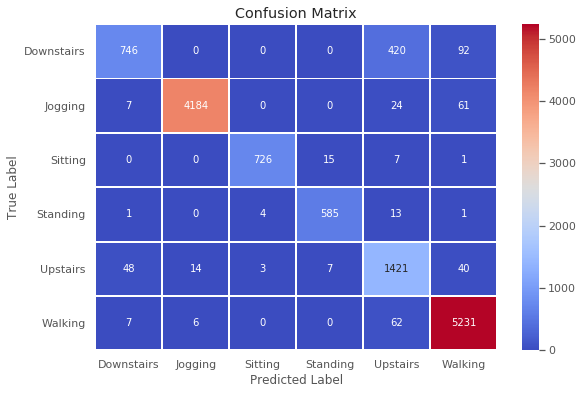

In [0]:
# Take the class with the highest probability from the test predictions
y_pred_test = model_conv_lstm.predict(X_test_conv, batch_size=batch_size)
max_y_pred_test = np.argmax(y_pred_test, axis = 1)
max_y_test = np.argmax(y_test_res, axis = 1)

#confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))
confusion_matrix(max_y_test, max_y_pred_test)

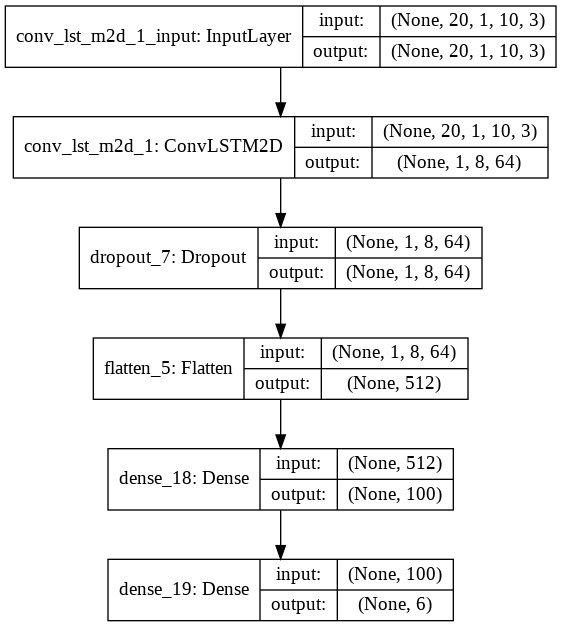

In [0]:
from keras.utils import plot_model
plot_model(model_conv_lstm, show_shapes=True, to_file='model_conv_lstm.png')